In [70]:
import os, os.path
import numpy as np
import pandas as pd
import data_structures as ds
import model_afolu as ma
import model_ippu as mi
import model_circular_economy as mc
import model_energy as me
import model_socioeconomic as se
from model_socioeconomic import Socioeconomic
import setup_analysis as sa
import support_functions as sf
import importlib
import time
import warnings
import matplotlib.pyplot as plt

importlib.reload(ds)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(ma)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)


<module 'model_socioeconomic' from '/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_socioeconomic.py'>

In [731]:
df_tmp = pd.read_csv("/Users/jsyme/Downloads/data_complete_future_2022_08_03_test.csv")



In [739]:
attr_lndu = sa.model_attributes.get_attribute_table(sa.model_attributes.subsec_name_lndu)

for k in attr_lndu.key_values:
    s = set(np.round(df_tmp[[x for x in df_tmp.columns if ("pij" in x) and (f"{k}_to" in x)]].sum(axis = 1), 5))
    print(f"{k}:\t{s}\n")

croplands:	{1.0}

forests_mangroves:	{1.0}

forests_primary:	{1.0}

forests_secondary:	{1.0}

grasslands:	{1.0}

other:	{1.0}

settlements:	{1.0}

wetlands:	{1.0}



In [770]:
os.listdir(os.path.dirname(sa.fp_csv_transition_probability_estimation_mean))

['.DS_Store',
 'transition_probs_by_region_mean.csv',
 'transition_probs_by_region_and_year.csv',
 'transition_probs_by_region_mean_with_target_growth-max_diagonal.csv',
 'transition_probs_by_region_mean_with_target_growth-max_diagonal_assumptions.pkl']

In [788]:
df_input[[x for x in df_input.columns if ("soil" in x) and ("fertilizer" in x)]]

qtyinit_soil_synthetic_fertilizer_kt
frac_soil_synthetic_fertilizer_urea

,demscalar_soil_fertilizer_n_per_area,ef_soil_ef1_n_organic_amerndments_fertilizer_n2o_dry_climate,ef_soil_ef1_n_organic_amerndments_fertilizer_n2o_wet_climate,ef_soil_ef1_n_synthetic_fertilizer_n2o_dry_climate,ef_soil_ef1_n_synthetic_fertilizer_n2o_wet_climate,frac_soil_gasf_n_volatilisation_synthetic_fertilizer_non_urea,frac_soil_gasf_n_volatilisation_synthetic_fertilizer_urea,frac_soil_gasm_n_volatilisation_organic_amendments_fertilizer,frac_soil_synthetic_fertilizer_urea,qtyinit_soil_synthetic_fertilizer_kt
0,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4
1,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4
2,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4
3,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4
4,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4
5,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4
6,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4
7,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4
8,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4
9,1,0.005,0.006,0.005,0.016,0.04667,0.15,0.21,0.592555,99.4


0    493.565189
1    493.565189
2    472.165666
3    492.282095
4    511.653073
Name: emission_co2e_co2_agrc_soil_carbon_mineral_soils, dtype: float64


<AxesSubplot:>

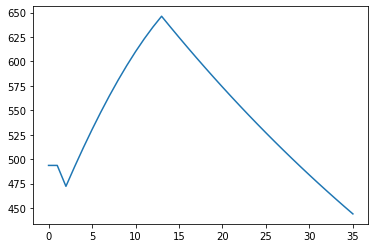

In [791]:
importlib.reload(ds)
importlib.reload(sa)
importlib.reload(ma)

df_tmp = pd.read_csv("/Users/jsyme/Downloads/data_complete_future_2022_08_03_test.csv")


country = "brazil"
optimization_approach = "max_diagonal"
df_input = df_tmp[df_tmp["Nation"] == country].reset_index(drop = True).copy();
# add any missing fields
df_base_inputs =  pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))
df_cat = df_base_inputs[[x for x in df_base_inputs.columns if x not in df_input.columns]]
df_input = pd.concat([df_input, df_cat], axis = 1)

# update some fields
df_input["frac_agrc_initial_yield_feed_sugar_cane"] = 0
df_input["lndu_reallocation_factor"] = 0
df_input["elasticity_agrc_sugar_cane_demand_to_income"] = 0.05
# update transitions
fields_ow = []

df_mean_transition = pd.read_csv(sa.fpt_csv_transition_probability_estimation_mean_with_growth%(optimization_approach))
df_mean_transition = df_mean_transition[
    df_mean_transition["country"].isin([country])
]
cols_loop = [x for x in df_mean_transition.columns if (x not in ["country", "year", "optimization_bound"])]
for k in cols_loop:
    k_new = f"pij_lndu_{k}"
    if k_new in df_input.columns:
        df_input[k_new] = float(df_mean_transition[k])
        fields_ow.append(k_new)
        
"""
df_input["factor_lndu_soil_carbon_grasslands"] = 1
dict_lndu_all = {
    "forests_secondary": {"croplands": 0.0005, "grasslands": 0.0001, "other": 0.0003, "wetlands": 0},
    "forests_mangroves": {"croplands": 0.0, "grasslands": 0.00, "other": 0.00, "forests_primary": 0.0, "forests_secondary": 0.0, "settlements": 0.0, "wetlands": 0.0},
    "settlements": {"croplands": 0.0001, "grasslands": 0.0001, "other": 0.00001, "wetlands": 0},
    "croplands": {"other": 0.0025},
    "grasslands": {"other": 0.005}

}
if False:
    for type_lndu in dict_lndu_all.keys():
        ##  adjust probabilities quickly
        dict_lndu = dict_lndu_all[type_lndu]
        for lndu in dict_lndu.keys():
            field_old = f"pij_lndu_{lndu}_to_{type_lndu}"
            field_to_add = f"pij_lndu_{lndu}_to_{lndu}"
            val_0 = float(df_input[field_old].iloc[0])
            val_new = dict_lndu[lndu]
            val_diff = val_0 - val_new
            df_input[field_old] = val_new
            df_input[field_to_add] = np.array(df_input[field_to_add]) + val_diff

#fields_p = [x for x in df_base_inputs.columns if ("pij_" in x)]
#for field in fields_p:
#    df_input[field] = np.array(df_base_inputs[field])
"""

model_afolu = ma.AFOLU(sa.model_attributes)
df_output = model_afolu.project(df_input)


print(df_output[[x for x in df_output.columns if (("emission_co2e" in x) and (("agrc" in x) or ("frst" in x)))]]["emission_co2e_co2_agrc_soil_carbon_mineral_soils"].head())
df_output[[x for x in df_output.columns if (("emission_co2e" in x) and (("agrc" in x) or ("frst" in x)))]]["emission_co2e_co2_agrc_soil_carbon_mineral_soils"].plot()


<AxesSubplot:>

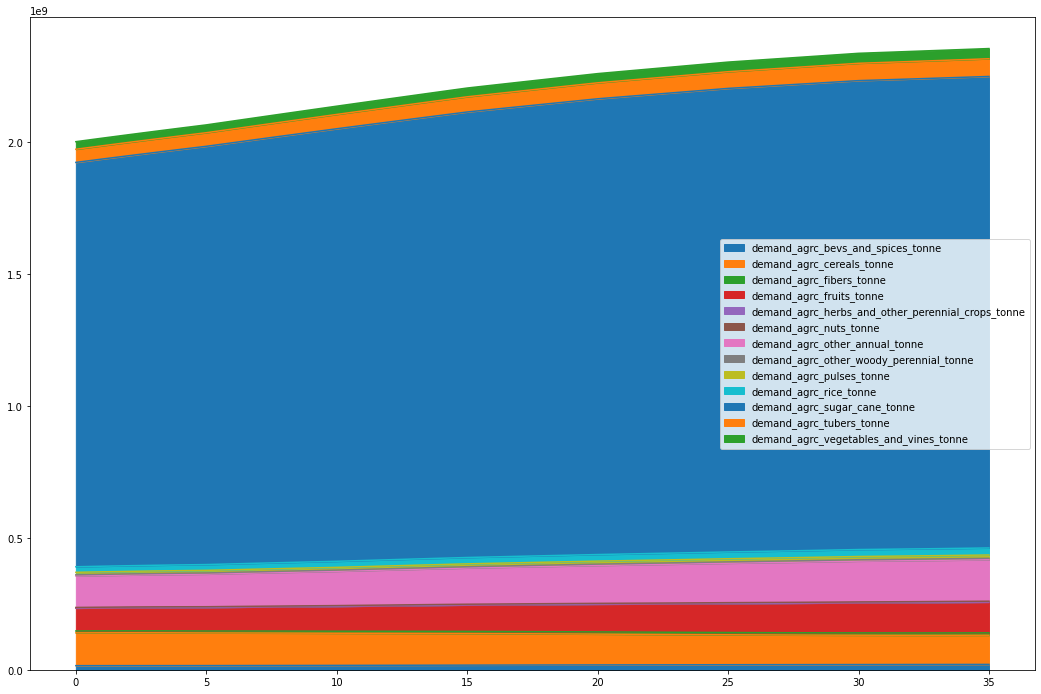

In [795]:
fig, ax = plt.subplots(figsize = (18, 12))
#ax.set_ylim(0, 50000000)
#df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" not in x)]].plot.area(ax = ax)
#df_output[[x for x in df_output.columns if ("emission_co2e_" in x) and ("subsector" not in x) and ("soil" in x) and ("agrc" not in x)]].plot.area(ax = ax)
#df_output[[x for x in df_output.columns if "net_imports_agrc" in x]].plot(ax = ax)
df_output[[x for x in df_output.columns if ("demand_agrc_" in x)]].plot.area(ax = ax)

<AxesSubplot:>

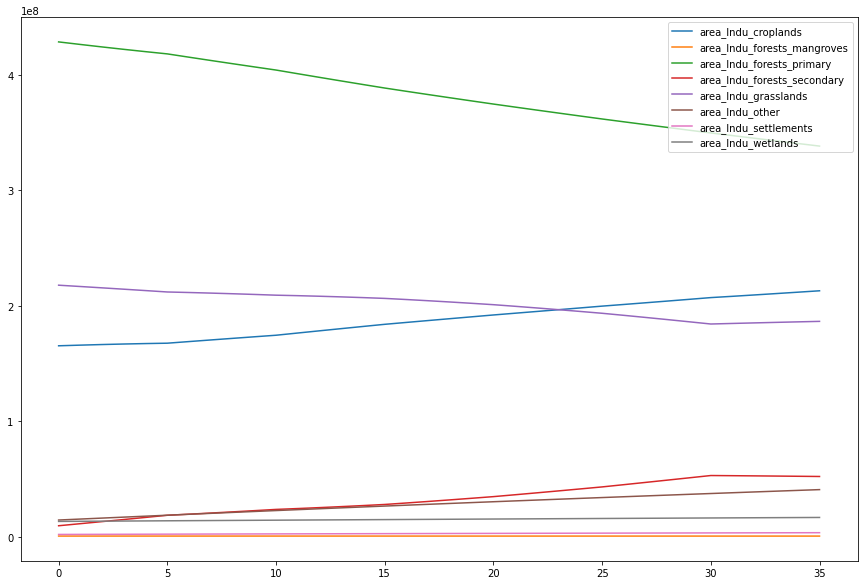

In [713]:
fix, ax = plt.subplots(figsize = (15, 10))
df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" not in x)]].plot(ax = ax)

In [261]:
print(sa.model_attributes.get_attribute_table("Land Use").key_values)
model_afolu.arrs_lndu_land_conv[0][:, 1]

['croplands', 'forests_mangroves', 'forests_primary', 'forests_secondary', 'grasslands', 'other', 'settlements', 'wetlands']


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.10646039e+01, 2.17770575e+04])

In [201]:
model_afolu.arrs_lndu_land_conv[1][:, 3]

array([1.42070899e+06, 0.00000000e+00, 0.00000000e+00, 8.52649751e+06,
       2.05676235e+06, 2.84337965e+06, 2.06758350e+03, 6.72316709e+04])

In [172]:
df_input[[x for x in df_input.columns if ("pij_" in x) and ("forests_secondary" in x)]]

,pij_lndu_croplands_to_forests_secondary,pij_lndu_forests_mangroves_to_forests_secondary,pij_lndu_forests_primary_to_forests_secondary,pij_lndu_forests_secondary_to_croplands,pij_lndu_forests_secondary_to_forests_mangroves,pij_lndu_forests_secondary_to_forests_primary,pij_lndu_forests_secondary_to_forests_secondary,pij_lndu_forests_secondary_to_grasslands,pij_lndu_forests_secondary_to_other,pij_lndu_forests_secondary_to_settlements,pij_lndu_forests_secondary_to_wetlands,pij_lndu_grasslands_to_forests_secondary,pij_lndu_other_to_forests_secondary,pij_lndu_settlements_to_forests_secondary,pij_lndu_wetlands_to_forests_secondary
0,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
1,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
2,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
3,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
4,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
5,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
6,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
7,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
8,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
9,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826


In [43]:

importlib.reload(ds)
importlib.reload(mi)

warnings.filterwarnings("ignore")

df_cs_integrated = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))

#model_afolu = ma.AFOLU(sa.model_attributes);
#model_circecon = mc.CircularEconomy(sa.model_attributes);
model_ippu = mi.IPPU(sa.model_attributes);
model_energy = me.NonElectricEnergy(sa.model_attributes);

# 
df_project_afolu = model_afolu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_afolu], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ce = model_circecon.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ce], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ip = model_ippu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ip], sa.model_attributes, "concatenate")

# pass in


In [62]:

importlib.reload(ds)
importlib.reload(sa)
importlib.reload(me)
#importlib.reload(ma)

warnings.filterwarnings("ignore")

df_cs_integrated = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))

model_afolu = ma.AFOLU(sa.model_attributes);
model_circecon = mc.CircularEconomy(sa.model_attributes);
model_ippu = mi.IPPU(sa.model_attributes);
model_energy = me.NonElectricEnergy(sa.model_attributes);

# 
df_project_afolu = model_afolu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_afolu], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ce = model_circecon.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ce], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ip = model_ippu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ip], sa.model_attributes, "concatenate")

# pass integrated df
df_project_en = model_energy.project(df_cs_integrated);
#df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_en], sa.model_attributes, "concatenate")



In [65]:
#importlib.reload(ds)
#importlib.reload(sa)
importlib.reload(me)
model_energy = me.NonElectricEnergy(sa.model_attributes);
df_project_en = model_energy.project(df_cs_integrated);

In [172]:
importlib.reload(sf)
importlib.reload(me)
#df_cs_integrated = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))
model_energy = me.NonElectricEnergy(sa.model_attributes)
df_project_en = model_energy.project(df_cs_integrated)

In [66]:
#df_project_en[[x for x in df_project_en if ("emission_co2e" in x) and ("inen" in x)]]

In [53]:
importlib.reload(me)
model_energy = me.NonElectricEnergy(sa.model_attributes);
df_project_en = model_energy.project(df_cs_integrated)




,time_period,emission_co2e_ch4_ccsq_direct_air_capture,emission_co2e_co2_ccsq_direct_air_capture,emission_co2e_n2o_ccsq_direct_air_capture,energy_demand_ccsq_electric_direct_air_capture,energy_demand_ccsq_non_electric_direct_air_capture,energy_demand_ccsq_non_electric_total,energy_demand_enfu_subsector_total_pj_ccsq_fuel_biofuels,energy_demand_enfu_subsector_total_pj_ccsq_fuel_coal,energy_demand_enfu_subsector_total_pj_ccsq_fuel_coke,...,energy_demand_enfu_subsector_total_pj_ccsq_fuel_hydropower,energy_demand_enfu_subsector_total_pj_ccsq_fuel_kerosene,energy_demand_enfu_subsector_total_pj_ccsq_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_ccsq_fuel_nuclear,energy_demand_enfu_subsector_total_pj_ccsq_fuel_oil,energy_demand_enfu_subsector_total_pj_ccsq_fuel_other,energy_demand_enfu_subsector_total_pj_ccsq_fuel_solar,energy_demand_enfu_subsector_total_pj_ccsq_fuel_solid_biomass,energy_demand_enfu_subsector_total_pj_ccsq_fuel_wind,emission_co2e_subsector_total_scoe
0,0,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
#df_project_ce = model_circecon.project(df_cs_integrated)
outs = sa.model_attributes.build_varlist(sa.model_attributes.subsec_name_enfu, variable_type = "input")#"Fugitive Emissions"
outs.sort()
for k in outs:
    if k not in df_cs_integrated.columns:
        print(k)

exports_enfu_pj_fuel_coal
exports_enfu_pj_fuel_natural_gas
exports_enfu_pj_fuel_oil
imports_enfu_pj_fuel_coal
imports_enfu_pj_fuel_natural_gas
imports_enfu_pj_fuel_oil
scalar_enfu_ratio_imports_to_exports_fuel_coal
scalar_enfu_ratio_imports_to_exports_fuel_natural_gas
scalar_enfu_ratio_imports_to_exports_fuel_oil


In [586]:
df_calib = pd.read_csv("/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/preliminary_calibration_info/df_waste_var_calib.csv")
df_calib.rename(columns = {"waste_var_calib": "variable"}, inplace = True)
df_ce_ranges = pd.read_excel(sa.excel_template_path("Circular Economy", "arg", "demo", True));


In [603]:
df_input = pd.read_csv("/Users/jsyme/Downloads/data_complete_future_2022_06_13.csv")
df_barbados = df_input[df_input["nation"] == "barbados"]

df_barbados[[x for x in df_barbados.columns if ("waso" in x) and ("frac" in x) and ("initial_composition_mun" in x)]]





,frac_waso_initial_composition_mun_chemical_industrial,frac_waso_initial_composition_mun_food,frac_waso_initial_composition_mun_glass,frac_waso_initial_composition_mun_metal,frac_waso_initial_composition_mun_nappies,frac_waso_initial_composition_mun_other,frac_waso_initial_composition_mun_paper,frac_waso_initial_composition_mun_plastic,frac_waso_initial_composition_mun_rubber_leather,frac_waso_initial_composition_mun_sludge,frac_waso_initial_composition_mun_textiles,frac_waso_initial_composition_mun_wood,frac_waso_initial_composition_mun_yard
72,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
73,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
74,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
75,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
76,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
77,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
78,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
79,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
80,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
81,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165


In [592]:
v = []

for subsec in sa.model_attributes.get_sector_subsectors("Circular Economy"):
    v0 = sa.model_attributes.build_varlist(subsec, variable_type = "input")
    v += list(zip([subsec for x in v0], v0))
    
df_v = pd.DataFrame(v, columns = ["subsector", "variable"])

#drops = set(df_calib["variable"]) - set(v)
#adds = list(set(v) - set(df_calib["variable"]))

#df_calib = df_calib[~df_calib["variable"].isin(drops)]

df_calib_out = pd.merge(df_v, df_calib, how = "left", on = ["variable"])
df_calib_out = pd.merge(df_calib_out, df_ce_ranges[["variable", "min_35", "max_35"]]).rename(columns = {"min_35": "Min Scalar", "max_35": "Max Scalar"}).sort_values(by = ["subsector", "variable"]).reset_index(drop = True)
df_calib_out.to_csv("/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/preliminary_calibration_info/df_ce_var_calib.csv", index = None, encoding = "UTF-8")



In [10]:
vars_afolu = sa.model_attributes.build_varlist("Livestock", variable_type = "input")
vars_afolu += sa.model_attributes.build_varlist("Agriculture", variable_type = "input")
vars_afolu = [x for x in vars_afolu if (x not in df_cs_integrated.columns)]
vars_afolu.sort()

for k in vars_afolu:
    print(k)



In [30]:

df_cs_integrated = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))

model_afolu = ma.AFOLU(sa.model_attributes);
model_circecon = mc.CircularEconomy(sa.model_attributes);
model_ippu = mi.IPPU(sa.model_attributes);
model_energy = me.NonElectricEnergy(sa.model_attributes);

# 
df_project_afolu = model_afolu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_afolu], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ce = model_circecon.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ce], sa.model_attributes, "concatenate")

# pass integrated df
#df_project_ippu = model_ippu.project(df_cs_integrated)
#df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ippu], sa.model_attributes, "concatenate")

#df_project_energy = model_energy.project(df_cs_integrated)

/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_afolu.py:369: RuntimeWarning: divide by zero encountered in true_divide
  vec_lvst_cc_init = vec_lvst_pop_init/(vec_initial_area[ind_pstr]*vec_lvst_pstr_weights)
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_afolu.py:406: RuntimeWarning: invalid value encountered in multiply
  vec_lvst_prod_proj = vec_lvst_cc_proj*area_pstr_proj*vec_lvst_pstr_weights


In [400]:
with open("/Users/jsyme/Desktop/tmp.txt") as fl:
    lns = fl.readlines()

dict_repl = {
    "recycled_": "recycled-", 
    "gas_petroleum_liquid": "gas-petroleum-liquid", 
    "gas_furnace": "gas-furnace", 
    "rubber_and_leather": "rubber-and-leather", 
    "other_product_manufacturing": "other-product-manufacturing",
    "natural_gas": "natural-gas",
    "lime_and_carbonite": "lime-and-carbonite",
    "solid_biomass": "solid-biomass"
}

pd.DataFrame([sf.str_replace(x, dict_repl).replace("frac_inen_energy_", "").replace("\n","").split("_") for x in lns]).to_csv("/Users/jsyme/Desktop/tmp.csv", index = None, encoding = "UTF-8")



In [406]:
df_test = pd.read_csv("/Users/jsyme/Desktop/tmp2.txt", header = None)
df_test
#pd.apply()

,0,1
0,coal,cement
1,coke,cement
2,diesel,cement
3,electricity,cement
4,gas-furnace,cement
...,...,...
229,kerosene,textiles
230,natural-gas,textiles
231,oil,textiles
232,solar,textiles


In [418]:
def func(row):
    
    return f"frac_inen_energy_{row[1]}_{row[0]}"
pr = df_test.apply(func, axis = 1)
for p in pr:
    print(p)

frac_inen_energy_cement_coal
frac_inen_energy_cement_coke
frac_inen_energy_cement_diesel
frac_inen_energy_cement_electricity
frac_inen_energy_cement_gas-furnace
frac_inen_energy_cement_gas-petroleum-liquid
frac_inen_energy_cement_gasoline
frac_inen_energy_cement_hydrogen
frac_inen_energy_cement_kerosene
frac_inen_energy_cement_natural-gas
frac_inen_energy_cement_oil
frac_inen_energy_cement_solar
frac_inen_energy_cement_solid-biomass
frac_inen_energy_chemicals_coal
frac_inen_energy_chemicals_coke
frac_inen_energy_chemicals_diesel
frac_inen_energy_chemicals_electricity
frac_inen_energy_chemicals_gas-furnace
frac_inen_energy_chemicals_gas-petroleum-liquid
frac_inen_energy_chemicals_gasoline
frac_inen_energy_chemicals_hydrogen
frac_inen_energy_chemicals_kerosene
frac_inen_energy_chemicals_natural-gas
frac_inen_energy_chemicals_oil
frac_inen_energy_chemicals_solar
frac_inen_energy_chemicals_solid-biomass
frac_inen_energy_electronics_coal
frac_inen_energy_electronics_coke
frac_inen_energy_el

In [388]:
#df_project_energy
sa.model_attributes.get_scalar(model_energy.modvar_ccsq_total_sequestration, "energy")
df_project_energy




{'CCSQ Fraction Heat Energy Demand Natural Gas': array([[6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272],
        [6.272]]),
 'CCSQ Fraction Heat Energy Demand Hydrogen': array([[0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
        [0.064],
    

In [372]:

df_neenergy_trajectories = df_cs_integrated
modvar_consumption = model_energy.modvar_ccsq_total_sequestration
arr_activity = None
arr_elasticity = None
arr_elastic_driver = None
dict_fuel_fracs = df_project_energy[0]
dict_fuel_frac_to_eff = None

##  initialize consumption and the fraction -> efficiency dictionary

# get consumption in terms of configuration output energy units
arr_consumption = sa.model_attributes.get_standard_variables(
    df_neenergy_trajectories,
    modvar_consumption,
    True,
    "array_base",
    expand_to_all_cats = True
)
arr_consumption *= sa.model_attributes.get_scalar(modvar_consumption, "energy")

# get the dictionary/run checks
if (dict_fuel_frac_to_eff is None):
    subsec_mv_consumption = sa.model_attributes.get_variable_subsector(modvar_consumption)
    if subsec_mv_consumption is not None:
        if subsec_mv_consumption == model_energy.subsec_name_scoe:
            dict_fuel_frac_to_eff = model_energy.modvar_dict_scoe_fuel_fractions_to_efficiency_factors
        elif subsec_mv_consumption == model_energy.subsec_name_ccsq:
            dict_fuel_frac_to_eff = model_energy.modvar_dict_ccsq_fuel_fractions_to_efficiency_factors
        else:
            raise ValueError(f"Error in project_energy_demands_by_fuel: unable to infer dictionary for dict_fuel_frac_to_eff based on model variable '{modvar_consumption}'.")
    else:
        raise ValueError(f"Invalid model variable '{modvar_consumption}' found in project_energy_demands_by_fuel: the variable is undefined.")
elif not isinstance(dict_fuel_frac_to_eff, dict):
    raise ValueError(f"Error in project_energy_demands_by_fuel: invalid type '{type(dict_fuel_frac_to_eff)}' specified for dict_fuel_frac_to_eff.")


##  estimate demand at point of use (account for heat delivery efficiency)

# loop over the different fuels to generate the true demand
arr_demand = 0
arr_frac_norm = 0
dict_consumption_fracs = {}

# use fractions of demand + efficiencies to calculate fraction of consumption
for modvar_fuel_frac in dict_fuel_fracs.keys():
    # get efficiency variable + variable arrays
    modvar_fuel_eff = dict_fuel_frac_to_eff.get(modvar_fuel_frac)
    arr_frac = dict_fuel_fracs.get(modvar_fuel_frac)
    arr_efficiency = sa.model_attributes.get_standard_variables(df_neenergy_trajectories, modvar_fuel_eff, True, "array_base", expand_to_all_cats = True)
    dict_consumption_fracs.update({modvar_fuel_frac: arr_frac/arr_efficiency})
    arr_frac_norm += dict_consumption_fracs[modvar_fuel_frac]
# 
for modvar_fuel_frac in dict_fuel_fracs.keys():
    dict_consumption_fracs.update({modvar_fuel_frac: dict_consumption_fracs[modvar_fuel_frac]/arr_frac_norm})
    
# project demand forward
arr_demand = np.nan_to_num(arr_consumption/arr_frac_norm, 0.0)
if (arr_elastic_driver is not None) and (arr_elasticity is not None):
    arr_growth_demand = sf.project_growth_scalar_from_elasticity(arr_elastic_driver, arr_elasticity, False, "standard")
    arr_demand = sf.do_array_mult(arr_demand[0]*arr_growth_demand, arr_activity)
else:
    #warnings.warn("Missing elasticity information found in 'project_energy_demands_by_fuel': using specified future demands.")
    arr_demand = sf.do_array_mult(arr_demand, arr_activity) if (arr_activity is not None) else arr_demand


dict_consumption_by_fuel_out = {}
for modvar_fuel_frac in dict_fuel_fracs.keys():
    # get efficiency variable + variable arrays
    modvar_fuel_eff = dict_fuel_frac_to_eff.get(modvar_fuel_frac)
    arr_frac = dict_fuel_fracs.get(modvar_fuel_frac)
    arr_efficiency = model_energy.model_attributes.get_standard_variables(df_neenergy_trajectories, modvar_fuel_eff, True, "array_base", expand_to_all_cats = True)
    # use consumption by fuel type and efficiency to get output demand for each fuel (in output energy units specified in config)
    arr_consumption_fuel = np.nan_to_num(arr_demand*arr_frac/arr_efficiency, 0.0)
    dict_consumption_by_fuel_out.update({modvar_fuel_frac: arr_consumption_fuel})

dict_consumption_by_fuel_out

{'CCSQ Fraction Heat Energy Demand Natural Gas': array([[0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98],
        [0.98]]),
 'CCSQ Fraction Heat Energy Demand Hydrogen': array([[0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [

#### sa.model_attributes.get_variable_unit_conversion_factor(
    model_energy.modvar_ccsq_total_sequestration,
    model_energy.modvar_ccsq_demand_per_co2,
    "mass"
)



In [264]:
sa.model_attributes.get_variable_unit_conversion_factor(
    model_energy.modvar_enfu_ef_combustion_stationary_n2o,
    model_energy.modvar_inen_en_prod_intensity_factor,
    "energy"
)

sa.model_attributes.get_energy_equivalent(
    sa.model_attributes.get_variable_characteristic(model_energy.modvar_enfu_ef_combustion_stationary_n2o, "$UNIT-ENERGY$"),
    sa.model_attributes.get_variable_characteristic(model_energy.modvar_inen_en_prod_intensity_factor, "$UNIT-ENERGY$")
)

1.0

In [231]:
df_project_energy[[x for x in df_project_energy.columns if "elect" in x]]

,energy_demand_electricity_scoe_total,energy_demand_scoe_electricity,energy_demand_scoe_electricity_commercial_municipal,energy_demand_scoe_electricity_other_se,energy_demand_scoe_electricity_residential,energy_demand_scoe_non_electric_heat_commercial_municipal,energy_demand_scoe_non_electric_heat_other_se,energy_demand_scoe_non_electric_heat_residential
0,18.477844,2.777544,3.899089,0.004677,14.574078,3.564286,0.015867,3.976518
1,18.909408,2.856708,4.066113,0.004882,14.838413,3.720306,0.016562,4.048641
2,19.288421,2.924859,4.205376,0.005052,15.077993,3.850292,0.017140,4.114011
3,19.615793,2.982100,4.316947,0.005189,15.293657,3.954266,0.017603,4.172854
4,19.961617,3.044339,4.444188,0.005345,15.512084,4.073106,0.018132,4.232452
5,20.300992,3.105671,4.570347,0.005500,15.725145,4.191003,0.018657,4.290585
6,20.657283,3.171300,4.709312,0.005670,15.942301,4.321062,0.019236,4.349836
7,21.023901,3.239795,4.857339,0.005852,16.160710,4.459770,0.019854,4.409428
8,21.411314,3.313534,5.020856,0.006054,16.384404,4.613217,0.020537,4.470463
9,21.819418,3.392552,5.200065,0.006275,16.613079,4.781624,0.021286,4.532857


In [212]:
importlib.reload(me)
model_energy = me.NonElectricEnergy(sa.model_attributes);
#dict_arrs_scoe_frac_energy, arr_scoe_deminit_hh_elec, arr_scoe_deminit_hh_heat, arr_scoe_deminit_mmmgdp_elec, arr_scoe_deminit_mmmgdp_heat = model_energy.project(df_cs_integrated)
#vec_hh, vec_gdp, vec_rates_gdp_per_capita = model_energy.project(df_cs_integrated)
#arr_scoe_enerdem_elasticity_hh_elec, arr_scoe_enerdem_elasticity_hh_heat, arr_scoe_enerdem_elasticity_mmmgdp_elec, arr_scoe_enerdem_elasticity_mmmgdp_heat = model_energy.project(df_cs_integrated)


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:1660: UserWarning: clean_partial_category_dictionary: Invalid categories values 'wood' dropped when cleaning the dictionary. Category values not found.
  warnings.warn(f"clean_partial_category_dictionary: Invalid categories values {missing_vals} dropped when cleaning the dictionary. Category values not found.")


In [ ]:
df_waste_run_arg = pd.read_excel("/Users/jsyme/Downloads/data_complete_future.xlsx")
df_waste_run_arg = df_waste_run_arg[df_waste_run_arg["nation"] == "argentina"]
df_waste_run_arg.drop(["nation"], axis = 1, inplace = True)

# fix some numbers
df_waste_run_arg["mcf_trww_treated_aerobic"] = 0.6
df_waste_run_arg["mcf_trww_treated_anaerobic"] = 0.6

df_transform = pd.read_csv("/Users/jsyme/Downloads/SolidWasteTransformation.csv")
df_transform_wali = pd.read_csv("/Users/jsyme/Downloads/SolidWasteTransformation.csv")





In [ ]:
#sa.model_attributes.get_standard_variables(df_cs_integrated, model_circecon.modvar_trww_frac_tow_removed)

df_complete_orig = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))
df_complete = pd.read_csv("/Users/jsyme/Downloads/data_complete_future.csv").rename(columns = {"gasrf_waso_biogass": "gasrf_waso_biogas"})
missing_fields = [x for x in df_complete_orig.columns if x not in df_complete.columns]
df_complete = df_complete[df_complete["nation"] == "argentina"].drop(["nation"], axis = 1)

for field in missing_fields:
    df_complete[field] = np.array(df_complete_orig[field])
    
# fake transformation
#[x for x in df_complete.columns if "frac_wali_ww_domestic_urban" in x]
df_complete_aerobic = df_complete.copy()
cols_fix = [x for x in df_complete_aerobic.columns if "frac_wali_ww_domestic_urban" in x]
for col in cols_fix:
    df_complete_aerobic[col] = 1 if ("_path_aerobic" in col) else 0
    
# fake transformation
#sa.model_attributes.get_standard_variables(df_waste_run_arg, model_circecon.modvar_wali_treatpath_anaerobic)
#[x for x in df_waste_run_arg.columns if "frac_wali_ww_domestic_urban" in x]
df_complete_anaerobic = df_complete.copy()
cols_fix = [x for x in df_complete_anaerobic.columns if "frac_wali_ww_domestic_urban" in x]
for col in cols_fix:
    df_complete_anaerobic[col] = 1 if ("_path_anaerobic" in col) else 0
    
    

model_afolu = ma.AFOLU(sa.model_attributes);
model_circecon = mc.CircularEconomy(sa.model_attributes);
model_ippu = mi.IPPU(sa.model_attributes);
model_energy = me.NonElectricEnergy(sa.model_attributes);

# 
df_project_afolu = model_afolu.project(df_complete)
df_cs_integrated = pd.merge(df_complete, df_project_afolu)
# pass integrated df
df_project_ce = model_circecon.project(df_cs_integrated);
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ce], sa.model_attributes, "concatenate")


# aerobic only
df_cs_integrated_aerobic = pd.merge(df_complete_aerobic, df_project_afolu)
df_project_ce_aerobic = model_circecon.project(df_cs_integrated_aerobic);
df_cs_integrated_aerobic= sf.merge_output_df_list([df_cs_integrated_aerobic, df_project_ce_aerobic], sa.model_attributes, "concatenate")


# anaerobic only
df_cs_integrated_anaerobic = pd.merge(df_complete_anaerobic, df_project_afolu)
df_project_ce_anaerobic = model_circecon.project(df_cs_integrated_anaerobic);
df_cs_integrated_anaerobic = sf.merge_output_df_list([df_cs_integrated_anaerobic, df_project_ce_anaerobic], sa.model_attributes, "concatenate")

# anaerobic only with capture
df_cs_integrated_anaerobic_wcap = pd.merge(df_complete_anaerobic, df_project_afolu)
df_cs_integrated_anaerobic_wcap["gasrf_trww_biogas_treated_anaerobic"] = 1#[0, 0, 0, 0] + list(np.array(range(32))/31)
df_project_ce_anaerobic_wcap = model_circecon.project(df_cs_integrated_anaerobic_wcap);
df_cs_integrated_anaerobic_wcap = sf.merge_output_df_list([df_cs_integrated_anaerobic_wcap, df_project_ce_anaerobic_wcap], sa.model_attributes, "concatenate")



df = pd.DataFrame({
    "trww_all_aerobic":  df_cs_integrated_aerobic["emission_co2e_subsector_total_trww"],
    "trww_baseline_numbers": df_cs_integrated["emission_co2e_subsector_total_trww"],
    "trww_all_anaerobic": df_cs_integrated_anaerobic["emission_co2e_subsector_total_trww"],
    "trww_all_anaerobic_wcap": df_cs_integrated_anaerobic_wcap["emission_co2e_subsector_total_trww"]
})

df2 = pd.DataFrame({
    "waso_all_aerobic":  df_cs_integrated_aerobic["emission_co2e_subsector_total_waso"],
    "waso_baseline_numbers": df_cs_integrated["emission_co2e_subsector_total_waso"],
    "waso_all_anaerobic": df_cs_integrated_anaerobic["emission_co2e_subsector_total_waso"],
    "waso_all_anaerobic_wcap": df_cs_integrated_anaerobic_wcap["emission_co2e_subsector_total_waso"]
})

pd.concat([df, df2], axis = 1).tail()

In [15]:
df_calib_waste = pd.read_csv("/Users/jsyme/Downloads/vector_calib_waste_26042022.csv")
all_cols = list(set(df_calib_waste.columns) & set(df_cs_integrated.columns))
all_cols.sort()

arr_cw = np.array(df_calib_waste[df_calib_waste["nation"] == "mexico"][all_cols])
arr_base = np.array(df_cs_integrated[all_cols])

In [22]:
v = (arr_cw/arr_base[0:35])[0]

np.where((v < np.inf) & (v > 100000))

<ipython-input-22-825789cc427c>:1: RuntimeWarning: divide by zero encountered in true_divide
  v = (arr_cw/arr_base[0:35])[0]


(array([22, 27]),)

In [420]:
vars_exist.drop_duplicates().reset_index(drop = True).sort_values(by = ["subsector", "variable"]).to_csv("/Users/jsyme/Desktop/tmp.csv", index = None, encoding = "UTF-8")

In [458]:
vars_exist = pd.read_excel(sa.excel_template_path("Energy", "arg", "demo", True))

ll = list(set(sa.model_attributes.get_input_output_fields(["Transportation Demand"])[0]) - set(vars_exist["variable"]))

for k in sorted(ll):
    print(k)


demscalar_trde_freight
demscalar_trde_private_and_public
demscalar_trde_regional


In [821]:
import support_functions as sf
import data_structures as ds
from model_socioeconomic import Socioeconomic
from model_ippu import IPPU
import pandas as pd
import numpy as np
import time


importlib.reload(ds)
importlib.reload(sa)

###########################
###                     ###
###     ENERGY MODEL    ###
###                     ###
###########################

class NonElectricEnergy:

    def __init__(self, attributes: ds.ModelAttributes):

        self.model_attributes = attributes
        self.required_dimensions = self.get_required_dimensions()
        self.required_subsectors, self.required_base_subsectors = self.get_required_subsectors()
        self.required_variables, self.output_variables = self.get_neenergy_input_output_fields()

        ##  set some model fields to connect to the attribute tables

        # Energy Fuel model variables
        self.modvar_enfu_ef_combustion_co2 = ":math:\\text{CO}_2 Combustion Emission Factor"
        self.modvar_enfu_ef_combustion_mobile_ch4 = ":math:\\text{CH}_4 Mobile Combustion Emission Factor"
        self.modvar_enfu_ef_combustion_mobile_n2o = ":math:\\text{N}_2\\text{O} Mobile Combustion Emission Factor"
        self.modvar_enfu_ef_combustion_stationary_ch4 = ":math:\\text{CH}_4 Stationary Combustion Emission Factor"
        self.modvar_enfu_ef_combustion_stationary_n2o = ":math:\\text{N}_2\\text{O} Stationary Combustion Emission Factor"
        self.modvar_enfu_volumetric_energy_density = "Volumetric Energy Density"
        
        # Industrial Energy model variables
        self.modvar_inen_demscalar = "Industrial Energy Demand Scalar"
        self.modvar_inen_emissions_ch4 = ":math:\\text{CH}_4 Emissions from Industrial Energy"
        self.modvar_inen_emissions_co2 = ":math:\\text{CO}_2 Emissions from Industrial Energy"
        self.modvar_inen_emissions_n2o = ":math:\\text{N}_2\\text{O} Emissions from Industrial Energy"
        self.modvar_inen_energy_demand_electricity = "Electrical Energy Demand from Industrial Energy"
        self.modvar_inen_energy_demand_electricity_agg = "Total Electrical Energy Demand from Industrial Energy"
        self.modvar_inen_energy_demand_total = "Energy Demand from Industrial Energy"
        self.modvar_inen_energy_demand_total_agg = "Total Energy Demand from Industrial Energy"
        self.modvar_inen_en_gdp_intensity_factor = "GDP Energy Intensity Factor"
        self.modvar_inen_en_prod_intensity_factor = "Production Energy Intesity Factor"
        self.modvar_inen_frac_en_coal = "Industrial Energy Fraction Coal"
        self.modvar_inen_frac_en_coke = "Industrial Energy Fraction Coke"
        self.modvar_inen_frac_en_diesel = "Industrial Energy Fraction Diesel"
        self.modvar_inen_frac_en_electricity = "Industrial Energy Fraction Electricity"
        self.modvar_inen_frac_en_furnace_gas = "Industrial Energy Fraction Furnace Gas"
        self.modvar_inen_frac_en_gasoline = "Industrial Energy Fraction Gasoline"
        self.modvar_inen_frac_en_hydrogen = "Industrial Energy Fraction Hydrogen"
        self.modvar_inen_frac_en_kerosene = "Industrial Energy Fraction Kerosene"
        self.modvar_inen_frac_en_natural_gas = "Industrial Energy Fraction Natural Gas"
        self.modvar_inen_frac_en_oil = "Industrial Energy Fraction Oil"
        self.modvar_inen_frac_en_pliqgas = "Industrial Energy Fraction Petroleum Liquid Gas"
        self.modvar_inen_frac_en_solar = "Industrial Energy Fraction Solar"
        self.modvar_inen_frac_en_solid_biomass = "Industrial Energy Fraction Solid Biomass"
        # fuel fractions to check summation over
        self.modvar_inen_list_fuel_fractions = [
            self.modvar_inen_frac_en_coal,
            self.modvar_inen_frac_en_coke,
            self.modvar_inen_frac_en_diesel,
            self.modvar_inen_frac_en_electricity,
            self.modvar_inen_frac_en_furnace_gas,
            self.modvar_inen_frac_en_gasoline,
            self.modvar_inen_frac_en_hydrogen,
            self.modvar_inen_frac_en_kerosene,
            self.modvar_inen_frac_en_natural_gas,
            self.modvar_inen_frac_en_oil,
            self.modvar_inen_frac_en_pliqgas,
            self.modvar_inen_frac_en_solar,
            self.modvar_inen_frac_en_solid_biomass
        ]
        
        # Transportation variables
        self.modvar_trns_average_vehicle_load_freight = "Average Freight Vehicle Load"
        self.modvar_trns_average_passenger_occupancy = "Average Passenger Vehicle Occupancy Rate"
        self.modvar_trns_electrical_efficiency = "Electrical Vehicle Efficiency"
        self.modvar_trns_ef_combustion_mobile_biofuels_ch4 = ":math:\\text{CH}_4 Biofuels Mobile Combustion Emission Factor"
        self.modvar_trns_ef_combustion_mobile_diesel_ch4 = ":math:\\text{CH}_4 Diesel Mobile Combustion Emission Factor"
        self.modvar_trns_ef_combustion_mobile_gasoline_ch4 = ":math:\\text{CH}_4 Gasoline Mobile Combustion Emission Factor"
        self.modvar_trns_ef_combustion_mobile_kerosene_ch4 = ":math:\\text{CH}_4 Kerosene Mobile Combustion Emission Factor"
        self.modvar_trns_ef_combustion_mobile_natural_gas_ch4 = ":math:\\text{CH}_4 Natural Gas Mobile Combustion Emission Factor"
        self.modvar_trns_ef_combustion_mobile_biofuels_n2o = ":math:\\text{N}_2\\text{O} Biofuels Mobile Combustion Emission Factor"
        self.modvar_trns_ef_combustion_mobile_diesel_n2o = ":math:\\text{N}_2\\text{O} Diesel Mobile Combustion Emission Factor"
        self.modvar_trns_ef_combustion_mobile_gasoline_n2o = ":math:\\text{N}_2\\text{O} Gasoline Mobile Combustion Emission Factor"
        self.modvar_trns_ef_combustion_mobile_kerosene_n2o = ":math:\\text{N}_2\\text{O} Kerosene Mobile Combustion Emission Factor"
        self.modvar_trns_ef_combustion_mobile_natural_gas_n2o = ":math:\\text{N}_2\\text{O} Natural Gas Mobile Combustion Emission Factor"
        self.modvar_trns_fuel_demand_biofuels_agg = "Total Fuel Demand Biofuels"
        self.modvar_trns_fuel_demand_diesel_agg = "Total Fuel Demand Diesel"
        self.modvar_trns_fuel_demand_gasoline_agg = "Total Fuel Demand Gasoline"
        self.modvar_trns_fuel_demand_hydrogen_agg = "Total Fuel Demand Hydrogen"
        self.modvar_trns_fuel_demand_kerosene_agg = "Total Fuel Demand Biofuels"
        self.modvar_trns_fuel_demand_natural_gas_agg = "Total Fuel Demand NaturalGas"
        self.modvar_trns_fuel_efficiency_biofuels = "Fuel Efficiency Biofuels"
        self.modvar_trns_fuel_efficiency_diesel = "Fuel Efficiency Diesel"
        self.modvar_trns_fuel_efficiency_gasoline = "Fuel Efficiency Gasoline"
        self.modvar_trns_fuel_efficiency_hydrogen = "Fuel Efficiency Hydrogen"
        self.modvar_trns_fuel_efficiency_kerosene = "Fuel Efficiency Kerosene"
        self.modvar_trns_fuel_efficiency_natural_gas = "Fuel Efficiency Natural Gas"
        self.modvar_trns_modeshare_freight = "Freight Transportation Mode Share"
        self.modvar_trns_modeshare_public_private = "Private and Public Transportation Mode Share"
        self.modvar_trns_modeshare_regional = "Regional Transportation Mode Share"
        self.modvar_trns_fuel_fraction_biofuels = "Transportation Mode Fuel Fraction Biofuels"
        self.modvar_trns_fuel_fraction_diesel = "Transportation Mode Fuel Fraction Diesel"
        self.modvar_trns_fuel_fraction_electricity = "Transportation Mode Fuel Fraction Electricity"
        self.modvar_trns_fuel_fraction_gasoline = "Transportation Mode Fuel Fraction Gasoline"
        self.modvar_trns_fuel_fraction_hydrogen = "Transportation Mode Fuel Fraction Hydrogen"
        self.modvar_trns_fuel_fraction_kerosene = "Transportation Mode Fuel Fraction Kerosene"
        self.modvar_trns_fuel_fraction_natural_gas = "Transportation Mode Fuel Fraction Natural Gas"
        self.modvar_tnrs_energy_demand_electricity = "Electrical Energy Demand from Transportation"
        self.modvar_tnrs_energy_demand_electricity_agg = "Total Electrical Energy Demand from Transportation"
        self.modvar_trns_emissions_ch4 = ":math:\\text{CH}_4 Emissions from Transportation"
        self.modvar_trns_emissions_co2 = ":math:\\text{CO}_2 Emissions from Transportation"
        self.modvar_trns_emissions_n2o = ":math:\\text{N}_2\\text{O} Emissions from Transportation"
        self.modvar_trns_vehicle_distance_traveled = "Total Vehicle Distance Traveled"
        
        # Transportation Demand variables
        self.modvar_trde_demand_scalar = "Transportation Demand Scalar"
        self.modvar_trde_elasticity_mtkm_to_gdp = "Elasticity of Megatonne-Kilometer Demand to GDP"
        self.modvar_trde_elasticity_pkm_to_gdp = "Elasticity of Passenger-Kilometer Demand per Capita to GDP per Capita"
        self.modvar_trde_demand_initial_mtkm = "Initial Megatonne-Kilometer Demand"
        self.modvar_trde_demand_initial_pkm_per_capita = "Initial per Capita Passenger-Kilometer Demand"
        self.modvar_trde_demand_mtkm = "Megatonne-Kilometer Demand"
        self.modvar_trde_demand_pkm = "Passenger-Kilometer Demand"
        


        
        # variables from other sectors
        self.modvar_ippu_qty_total_production = "Industrial Production"

        # add other model classes
        self.model_socioeconomic = Socioeconomic(self.model_attributes)
        self.model_ippu = IPPU(self.model_attributes)

        # optional integration variables (uses calls to other model classes)
        self.integration_variables = self.set_integrated_variables()

        ##  MISCELLANEOUS VARIABLES
        self.time_periods, self.n_time_periods = self.model_attributes.get_time_periods()
        self.enfu_fuel_electricity = self.get_electricity_fuel()
        
        # fuel variables dictionary for transportation
        self.dict_trns_fuel_categories_to_fuel_variables, self.dict_trns_fuel_categories_to_unassigned_fuel_variables = self.get_dict_trns_fuel_categories_to_fuel_variables()
        # some derivate lists of variables
        self.modvars_trns_list_fuel_fraction = sa.model_attributes.get_vars_by_assigned_class_from_akaf(
            model_energy.dict_trns_fuel_categories_to_fuel_variables,
            "fuel_fraction"
        )
        self.modvars_trns_list_fuel_efficiency = sa.model_attributes.get_vars_by_assigned_class_from_akaf(
            model_energy.dict_trns_fuel_categories_to_fuel_variables,
            "fuel_efficiency"
        )



    ##  FUNCTIONS FOR MODEL ATTRIBUTE DIMENSIONS

    def check_df_fields(self, 
        df_neenergy_trajectories: pd.DataFrame, 
        subsector: str = "All",
        var_type: str = "input",
        msg_prepend: str = None
    ):
        if subsector == "All":
            check_fields = self.required_variables
            msg_prepend = "Energy"
        else:
            self.model_attributes.check_subsector(subsector)
            if var_type == "input":
                check_fields, ignore_fields = self.model_attributes.get_input_output_fields(["Economy", "General", subsector])
            elif var_type == "output":
                ignore_fields, check_fields = self.model_attributes.get_input_output_fields([subsector])
            else: 
                raise ValueError(f"Invalid var_type '{var_type}' in check_df_fields: valid types are 'input', 'output'")
            msg_prepend = msg_prepend if (msg_prepend is not None) else subsector
        sf.check_fields(df_neenergy_trajectories, check_fields, f"{msg_prepend} projection cannot proceed: fields ")
    
    def get_electricity_fuel(self):
        return self.model_attributes.get_categories_from_attribute_characteristic("Energy Fuels", {self.model_attributes.field_enfu_electricity_demand_category: 1})[0]
        
    def get_required_subsectors(self):
        ## TEMPORARY
        subsectors = ["Industrial Energy", "Energy Fuels", "Transportation", "Transportation Demand"]#self.model_attributes.get_setor_subsectors("Energy")
        subsectors_base = subsectors.copy()
        subsectors += ["Economy", "General"]
        return subsectors, subsectors_base

    def get_required_dimensions(self):
        ## TEMPORARY - derive from attributes later
        required_doa = [self.model_attributes.dim_time_period]
        return required_doa

    def get_neenergy_input_output_fields(self):
        required_doa = [self.model_attributes.dim_time_period]
        required_vars, output_vars = self.model_attributes.get_input_output_fields(self.required_subsectors)
        
        return required_vars + self.get_required_dimensions(), output_vars
    
    
    ##  function to set alternative sets of input variables; leave empty for now
    def get_neenergy_optional_switch_variables(self) -> dict:
        """
           get_neenergy_optional_switch_variables() defines dictionaries of lists of variables. Returns a nested dictionary specified in the class.
           
           Output Structure
           ----------------
           {
               "varset_1": {
                   "primary": [primary variables...], 
                   "secondary": [primary variables...]
                },
               "varset_2": {
                   "primary": [primary variables...], 
                   "secondary": [primary variables...]
                },
               ...
           }
           
           Notes
           -----
           - In each dictionary, variables from the "primary" key *or* variables from the "secondary" key must be defined. In general, "primary" variables are associated with integration. In the absence of these variables, secondary variables are generally calculated endogenously. 
           - Each variable set represents a different approach
           - If all variables are defined in the input data frame, then the approach associated with "primary" variables is used.
        """
        
        return {}
    
    
    # variables required to integration
    def set_integrated_variables(self):
        # set the integration variables
        list_vars_required_for_integration = [
            self.modvar_ippu_qty_total_production
        ]
        
        # in Energy, update required variables
        for modvar in list_vars_required_for_integration:
            subsec = self.model_attributes.get_variable_subsector(modvar)
            new_vars = self.model_attributes.build_varlist(subsec, modvar)
            self.required_variables += new_vars
        
        # sot required variables and ensure no double counting
        self.required_variables = list(set(self.required_variables))
        self.required_variables.sort()

        return list_vars_required_for_integration

    
    

    ######################################
    #    SUBSECTOR SPECIFIC FUNCTIONS    #
    ######################################

    ##  transportation variables from fuel categories as specified by a matchstring
    def get_dict_trns_fuel_categories_to_fuel_variables(self):
        """
            use get_dict_trns_fuel_categories_to_fuel_variables to return a dictionary with fuel categories as keys based on the Transportation attribute table;
            {cat_fuel: {"fuel_efficiency": VARNAME_FUELEFFICIENCY, ...}}

            for each key, the dict includes variables associated with the fuel cat_fuel:

            - "fuel_efficiency"
            - "fuel_fraction"
            - "ef_ch4"
            - "ef_n2o"

        """

        dict_out = self.model_attributes.assign_keys_from_attribute_fields(
            "Transportation",
            "cat_fuel",
            {
                "Fuel Efficiency": "fuel_efficiency",
                "Fuel Fraction": "fuel_fraction",
                ":math:\\text{CH}_4": "ef_ch4",
                ":math:\\text{N}_2\\text{O}": "ef_n2o",
                "Total Fuel Demand": "total_fuel_demand"
            },
            "varreqs_partial",
            True
        )

        return dict_out
    
    
    ########################################
    ###                                  ###
    ###    PRIMARY PROJECTION METHODS    ###
    ###                                  ###
    ########################################
    
    ##  industrial energy model
    def project_industrial_energy(
        self,
        df_neenergy_trajectories: pd.DataFrame,
        vec_gdp: np.ndarray,
        dict_dims: dict = None,
        n_projection_time_periods: int = None,
        projection_time_periods: list = None
    ) -> pd.DataFrame:

        """
            project_industrial_energy can be called from other sectors to simplify calculation of industrial energy.

            Function Arguments
            ------------------
            df_neenergy_trajectories: pd.DataFrame of input variables

            vec_gdp: np.ndarray vector of gdp (requires len(vec_gdp) == len(df_neenergy_trajectories))

            dict_dims: dict of dimensions (returned from check_projection_input_df). Default is None.

            n_projection_time_periods: int giving number of time periods (returned from check_projection_input_df). Default is None.

            projection_time_periods: list of time periods (returned from check_projection_input_df). Default is None.


            Notes
            -----
            If any of dict_dims, n_projection_time_periods, or projection_time_periods are unspecified (expected if ran outside of Energy.project()), self.model_attributes.check_projection_input_df wil be run

        """

        # allows production to be run outside of the project method
        if type(None) in set([type(x) for x in [dict_dims, n_projection_time_periods, projection_time_periods]]):
            dict_dims, df_neenergy_trajectories, n_projection_time_periods, projection_time_periods = self.model_attributes.check_projection_input_df(df_neenergy_trajectories, True, True, True)


        ##  CATEGORY AND ATTRIBUTE INITIALIZATION
        pycat_enfu = self.model_attributes.get_subsector_attribute("Energy Fuels", "pycategory_primary")
        pycat_inen = self.model_attributes.get_subsector_attribute("Industrial Energy", "pycategory_primary")
        pycat_ippu = self.model_attributes.get_subsector_attribute("IPPU", "pycategory_primary")
        # attribute tables
        attr_enfu = self.model_attributes.dict_attributes[pycat_enfu]
        attr_inen = self.model_attributes.dict_attributes[pycat_inen]
        attr_ippu = self.model_attributes.dict_attributes[pycat_ippu]


        ##  OUTPUT INITIALIZATION

        df_out = [df_neenergy_trajectories[self.required_dimensions].copy()]


        ############################
        #    MODEL CALCULATIONS    #
        ############################

        # first, retrieve energy fractions and ensure they sum to 1
        dict_arrs_inen_frac_energy = sa.model_attributes.get_multivariables_with_bounded_sum_by_category(
            df_cs_integrated,
            model_energy.modvar_inen_list_fuel_fractions,
            1,
            force_sum_equality = True,
            msg_append = "Energy fractions by category do not sum to 1. See definition of dict_arrs_inen_frac_energy."
        )


        ##  GET ENERGY INTENSITIES

        # get production-based emissions - start with production, energy demand
        arr_inen_prod = self.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_ippu_qty_total_production, True, "array_base", expand_to_all_cats = True)
        arr_inen_prod_energy_intensity = self.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_inen_en_prod_intensity_factor, True, "array_base", expand_to_all_cats = True)
        scalar_inen_prod_intensity_to_total_prod = self.model_attributes.get_mass_equivalent(
            self.model_attributes.get_variable_characteristic(self.modvar_inen_en_prod_intensity_factor, "$UNIT-MASS$"),
            self.model_attributes.get_variable_characteristic(self.modvar_ippu_qty_total_production, "$UNIT-MASS$")
        )
        # energy intensity due to production in terms of units self.modvar_ippu_qty_total_production
        arr_inen_energy_demand = arr_inen_prod*arr_inen_prod_energy_intensity*scalar_inen_prod_intensity_to_total_prod
        # gdp-based emissions - get intensity, multiply by gdp, and scale to match energy units of production
        arr_inen_gdp_energy_intensity = self.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_inen_en_gdp_intensity_factor, True, "array_base", expand_to_all_cats = True)
        scalar_inen_gdp_energy_to_prod_energy = self.model_attributes.get_energy_equivalent(
            self.model_attributes.get_variable_characteristic(self.modvar_inen_en_gdp_intensity_factor, "$UNIT-ENERGY$"),
            self.model_attributes.get_variable_characteristic(self.modvar_inen_en_prod_intensity_factor, "$UNIT-ENERGY$")
        )
        arr_inen_energy_demand += (arr_inen_gdp_energy_intensity.transpose() * vec_gdp).transpose()*scalar_inen_gdp_energy_to_prod_energy


        ##  GET EMISSION FACTORS

        # methane - scale to ensure energy units are the same
        arr_inen_ef_by_fuel_ch4 = sa.model_attributes.get_standard_variables(df_cs_integrated, self.modvar_enfu_ef_combustion_stationary_ch4, return_type = "array_units_corrected")
        arr_inen_ef_by_fuel_ch4 *= self.model_attributes.get_energy_equivalent(
            self.model_attributes.get_variable_characteristic(self.modvar_enfu_ef_combustion_stationary_ch4, "$UNIT-ENERGY$"),
            self.model_attributes.get_variable_characteristic(self.modvar_inen_en_prod_intensity_factor, "$UNIT-ENERGY$")
        )
        # carbon dioxide - scale to ensure energy units are the same
        arr_inen_ef_by_fuel_co2 = sa.model_attributes.get_standard_variables(df_cs_integrated, self.modvar_enfu_ef_combustion_co2, return_type = "array_units_corrected")
        arr_inen_ef_by_fuel_co2 *= self.model_attributes.get_energy_equivalent(
            self.model_attributes.get_variable_characteristic(self.modvar_enfu_ef_combustion_co2, "$UNIT-ENERGY$"),
            self.model_attributes.get_variable_characteristic(self.modvar_inen_en_prod_intensity_factor, "$UNIT-ENERGY$")
        )
        # nitrous oxide - scale to ensure energy units are the same
        arr_inen_ef_by_fuel_n2o = sa.model_attributes.get_standard_variables(df_cs_integrated, self.modvar_enfu_ef_combustion_stationary_n2o, return_type = "array_units_corrected")
        arr_inen_ef_by_fuel_n2o *= self.model_attributes.get_energy_equivalent(
            self.model_attributes.get_variable_characteristic(self.modvar_enfu_ef_combustion_stationary_n2o, "$UNIT-ENERGY$"),
            self.model_attributes.get_variable_characteristic(self.modvar_inen_en_prod_intensity_factor, "$UNIT-ENERGY$")
        )


        ##  CALCULATE EMISSIONS AND ELECTRICITY DEMAND

        # initialize electrical demand to pass and output emission arrays
        arr_inen_demand_electricity = 0.0
        arr_inen_demand_electricity_total = 0.0
        arr_inen_demand_total = 0.0
        arr_inen_demand_total_total = 0.0
        arr_inen_emissions_ch4 = 0.0
        arr_inen_emissions_co2 = 0.0
        arr_inen_emissions_n2o = 0.0
        # loop over fuels to
        for var_ener_frac in self.modvar_inen_list_fuel_fractions:
            # retrive the fuel category
            cat_fuel = ds.clean_schema(self.model_attributes.get_variable_attribute(var_ener_frac, pycat_enfu))
            # get the demand for the current fuel
            arr_inen_endem_cur_fuel = dict_arrs_inen_frac_energy[var_ener_frac].copy()
            arr_inen_endem_cur_fuel *= arr_inen_energy_demand
            # get the category value index and
            index_cat_fuel = attr_enfu.get_key_value_index(cat_fuel)
            arr_inen_emissions_ch4 += arr_inen_endem_cur_fuel.transpose()*arr_inen_ef_by_fuel_ch4[:, index_cat_fuel]
            arr_inen_emissions_co2 += arr_inen_endem_cur_fuel.transpose()*arr_inen_ef_by_fuel_co2[:, index_cat_fuel]
            arr_inen_emissions_n2o += arr_inen_endem_cur_fuel.transpose()*arr_inen_ef_by_fuel_n2o[:, index_cat_fuel]
            # add electricity demand and total energy demand
            arr_inen_demand_electricity += arr_inen_endem_cur_fuel if (cat_fuel == self.enfu_fuel_electricity) else 0.0
            arr_inen_demand_electricity_total += arr_inen_endem_cur_fuel.sum(axis = 1) if (cat_fuel == self.enfu_fuel_electricity) else 0.0
            arr_inen_demand_total += arr_inen_endem_cur_fuel
            arr_inen_demand_total_total += arr_inen_endem_cur_fuel.sum(axis = 1)

        # transpose outputs
        arr_inen_emissions_ch4 = arr_inen_emissions_ch4.transpose()
        arr_inen_emissions_co2 = arr_inen_emissions_co2.transpose()
        arr_inen_emissions_n2o = arr_inen_emissions_n2o.transpose()
        # set energy data frames
        scalar_energy = self.model_attributes.get_scalar(self.modvar_inen_en_prod_intensity_factor, "energy")


        ##  BUILD OUTPUT DFs

        df_out += [
            self.model_attributes.array_to_df(arr_inen_emissions_ch4, self.modvar_inen_emissions_ch4, False, True),
            self.model_attributes.array_to_df(arr_inen_emissions_co2, self.modvar_inen_emissions_co2, False, True),
            self.model_attributes.array_to_df(arr_inen_emissions_n2o, self.modvar_inen_emissions_n2o, False, True),
            self.model_attributes.array_to_df(arr_inen_demand_electricity*scalar_energy, self.modvar_inen_energy_demand_electricity, False, True),
            self.model_attributes.array_to_df(arr_inen_demand_electricity_total*scalar_energy, self.modvar_inen_energy_demand_electricity_agg, False),
            self.model_attributes.array_to_df(arr_inen_demand_total*scalar_energy, self.modvar_inen_energy_demand_total, False, True),
            self.model_attributes.array_to_df(arr_inen_demand_total_total*scalar_energy, self.modvar_inen_energy_demand_total_agg, False)
        ]

        # concatenate and add subsector emission totals
        df_out = sf.merge_output_df_list(df_out, self.model_attributes, "concatenate")
        self.model_attributes.add_subsector_emissions_aggregates(df_out, ["Industrial Energy"], False)

        return df_out
    
    
    
    ##  transportation demands
    def project_transportation_demand(self,
        df_neenergy_trajectories: pd.DataFrame,
        vec_pop: np.ndarray,
        vec_rates_gdp: np.ndarray,
        vec_rates_gdp_per_capita: np.ndarray,
        dict_dims: dict = None,
        n_projection_time_periods: int = None,
        projection_time_periods: list = None
    ) -> pd.DataFrame:

        """
            project_transportation_demand can be called from other sectors to simplify calculation of transportation demands and associated metrics.

            Function Arguments
            ------------------
            df_neenergy_trajectories: pd.DataFrame of input variables
            
            vec_pop: np.ndarray vector of population (requires len(vec_rates_gdp) == len(df_neenergy_trajectories))

            vec_rates_gdp: np.ndarray vector of gdp growth rates (v_i = growth rate from t_i to t_{i + 1}) (requires len(vec_rates_gdp) == len(df_neenergy_trajectories) - 1)

            vec_rates_gdp_per_capita: np.ndarray vector of gdp per capita growth rates (v_i = growth rate from t_i to t_{i + 1}) (requires len(vec_rates_gdp_per_capita) == len(df_neenergy_trajectories) - 1)

            dict_dims: dict of dimensions (returned from check_projection_input_df). Default is None.

            n_projection_time_periods: int giving number of time periods (returned from check_projection_input_df). Default is None.

            projection_time_periods: list of time periods (returned from check_projection_input_df). Default is None.


            Notes
            -----
            If any of dict_dims, n_projection_time_periods, or projection_time_periods are unspecified (expected if ran outside of Energy.project()), self.model_attributes.check_projection_input_df wil be run

        """

        # allows production to be run outside of the project method
        if type(None) in set([type(x) for x in [dict_dims, n_projection_time_periods, projection_time_periods]]):
            dict_dims, df_neenergy_trajectories, n_projection_time_periods, projection_time_periods = self.model_attributes.check_projection_input_df(df_neenergy_trajectories, True, True, True)


        ##  CATEGORY AND ATTRIBUTE INITIALIZATION
        pycat_enfu = self.model_attributes.get_subsector_attribute("Energy Fuels", "pycategory_primary")
        pycat_trde = self.model_attributes.get_subsector_attribute("Transportation Demand", "pycategory_primary")
        pycat_trns = self.model_attributes.get_subsector_attribute("Transportation", "pycategory_primary")
        # attribute tables
        attr_enfu = self.model_attributes.dict_attributes[pycat_enfu]
        attr_trde = self.model_attributes.dict_attributes[pycat_trde]
        attr_trns = self.model_attributes.dict_attributes[pycat_trns]


        ##  OUTPUT INITIALIZATION

        df_out = [df_neenergy_trajectories[self.required_dimensions].copy()]


        ############################
        #    MODEL CALCULATIONS    #
        ############################

        # get the demand scalar
        array_trde_demscalar = sa.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_trde_demand_scalar, return_type = "array_base", expand_to_all_cats = True, var_bounds = (0, np.inf))
        # start with freight/megaton km demands
        array_trde_dem_init_freight = sa.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_trde_demand_initial_mtkm, return_type = "array_base", expand_to_all_cats = True)
        array_trde_elast_freight_demand_to_gdp = sa.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_trde_elasticity_mtkm_to_gdp, return_type = "array_base", expand_to_all_cats = True)
        array_trde_growth_freight_dem_by_cat = sf.project_growth_scalar_from_elasticity(vec_rates_gdp, array_trde_elast_freight_demand_to_gdp, False, "standard")
        # multiply and add to the output
        array_trde_freight_dem_by_cat = array_trde_dem_init_freight[0]*array_trde_growth_freight_dem_by_cat
        array_trde_freight_dem_by_cat *= array_trde_demscalar
        df_out.append(
            self.model_attributes.array_to_df(array_trde_freight_dem_by_cat, self.modvar_trde_demand_mtkm, False, True)
        )
        
        # deal with person-km
        array_trde_dem_init_passenger = sa.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_trde_demand_initial_pkm_per_capita, return_type = "array_base", expand_to_all_cats = True)
        array_trde_elast_passenger_demand_to_gdppc = sa.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_trde_elasticity_pkm_to_gdp, return_type = "array_base", expand_to_all_cats = True)
        array_trde_growth_passenger_dem_by_cat = sf.project_growth_scalar_from_elasticity(vec_rates_gdp_per_capita, array_trde_elast_passenger_demand_to_gdppc, False, "standard")
        # project the growth in per capita, multiply by population, then add it to the output
        array_trde_passenger_dem_by_cat = array_trde_dem_init_passenger[0]*array_trde_growth_passenger_dem_by_cat
        array_trde_passenger_dem_by_cat = (array_trde_passenger_dem_by_cat.transpose()*vec_pop).transpose()
        array_trde_passenger_dem_by_cat *= array_trde_demscalar
        df_out.append(
            self.model_attributes.array_to_df(array_trde_passenger_dem_by_cat, self.modvar_trde_demand_pkm, False, True)
        )
        
        # build output dataframe
        df_out = sf.merge_output_df_list(df_out, self.model_attributes, "concatenate")
        
        return df_out
    

    
    ##  other energy: stationary emissions and carbon capture and sequestration
    def project_oesc():
        
        return 0
    
    
    ##  primary method
    def project(self, df_neenergy_trajectories):
    
        """
            The Energy.project() method takes a data frame of input variables (ordered by time series) and returns a data frame of output variables (model projections for energy--including industrial energy, transportation, stationary emissions, carbon capture and sequestration, and electricity) the same order.

            Function Arguments
            ------------------
            df_neenergy_trajectories: pd.DataFrame with all required input fields as columns. The model will not run if any required variables are missing, but errors will detail which fields are missing.

            Notes
            -----
            - The .project() method is designed to be parallelized or called from command line via __main__ in run_sector_models.py.
            - df_neenergy_trajectories should have all input fields required (see Energy.required_variables for a list of variables to be defined)
            - the df_neenergy_trajectories.project method will run on valid time periods from 1 .. k, where k <= n (n is the number of time periods). By default, it drops invalid time periods. If there are missing time_periods between the first and maximum, data are interpolated.
        """

        ##  CHECKS

        # make sure socioeconomic variables are added and
        df_neenergy_trajectories, df_se_internal_shared_variables = self.model_socioeconomic.project(df_neenergy_trajectories)
        # check that all required fields are contained—assume that it is ordered by time period
        self.check_df_fields(df_neenergy_trajectories)
        dict_dims, df_neenergy_trajectories, n_projection_time_periods, projection_time_periods = self.model_attributes.check_projection_input_df(df_neenergy_trajectories, True, True, True)

        
        ##  CATEGORY AND ATTRIBUTE INITIALIZATION
        pycat_fuel = self.model_attributes.get_subsector_attribute("Energy Fuels", "pycategory_primary")
        pycat_gnrl = self.model_attributes.get_subsector_attribute("General", "pycategory_primary")
        pycat_inen = self.model_attributes.get_subsector_attribute("Industrial Energy", "pycategory_primary")
        pycat_ippu = self.model_attributes.get_subsector_attribute("IPPU", "pycategory_primary")
        pycat_oesc = self.model_attributes.get_subsector_attribute("Other Energy: Stationary Emissions and Carbon Capture and Sequestration", "pycategory_primary")
        pycat_trns = self.model_attributes.get_subsector_attribute("Transportation", "pycategory_primary")
        # attribute tables
        attr_fuel = self.model_attributes.dict_attributes[pycat_fuel]
        attr_gnrl = self.model_attributes.dict_attributes[pycat_gnrl]
        attr_inen = self.model_attributes.dict_attributes[pycat_inen]
        attr_ippu = self.model_attributes.dict_attributes[pycat_ippu]
        attr_oesc = self.model_attributes.dict_attributes[pycat_oesc]
        attr_trns = self.model_attributes.dict_attributes[pycat_trns]


        ##  ECON/GNRL VECTOR AND ARRAY INITIALIZATION

        # get some vectors from the se model
        vec_gdp = self.model_attributes.get_standard_variables(df_neenergy_trajectories, self.model_socioeconomic.modvar_econ_gdp, False, return_type = "array_base")
        vec_pop = self.model_attributes.get_standard_variables(df_neenergy_trajectories, self.model_socioeconomic.modvar_gnrl_pop_total, False, return_type = "array_base")
        array_pop = self.model_attributes.get_standard_variables(df_neenergy_trajectories, self.model_socioeconomic.modvar_gnrl_subpop, False, return_type = "array_base")
        vec_gdp_per_capita = np.array(df_se_internal_shared_variables["vec_gdp_per_capita"])
        vec_rates_gdp = np.array(df_se_internal_shared_variables["vec_rates_gdp"].dropna())
        vec_rates_gdp_per_capita = np.array(df_se_internal_shared_variables["vec_rates_gdp_per_capita"].dropna())

        
        ##  OUTPUT INITIALIZATION

        df_out = [df_neenergy_trajectories[self.required_dimensions].copy()]
        
        

        #########################################
        #    MODEL CALCULATIONS BY SUBSECTOR    #
        #########################################
        
        # add industrial energy, transportation, and OESC
        df_out.append(self.project_industrial_energy(df_neenergy_trajectories, vec_gdp, dict_dims, n_projection_time_periods, projection_time_periods))
        df_out.append(self.project_transportation(df_neenergy_trajectories, vec_pop, vec_rates_gdp, vec_rates_gdp_per_capita, dict_dims, n_projection_time_periods, projection_time_periods))
        
        # concatenate and add subsector emission totals
        df_out = sf.merge_output_df_list(df_out, self.model_attributes, "concatenate")
        
        return df_out
    

    

    ##  transportation
    def project_transportation(self,
        df_neenergy_trajectories: pd.DataFrame,
        vec_pop: np.ndarray,
        vec_rates_gdp: np.ndarray,
        vec_rates_gdp_per_capita: np.ndarray,
        dict_dims: dict = None,
        n_projection_time_periods: int = None,
        projection_time_periods: list = None
    ) -> pd.DataFrame:

        """
            project_transportation can be called from other sectors to simplify calculation of transportation emissions and associated metrics. Requires NonElectricEnergy.project_transportation_demand() and all variables from the transportation demand sector

            Function Arguments
            ------------------
            df_neenergy_trajectories: pd.DataFrame of input variables
            
            vec_pop: np.ndarray vector of population (requires len(vec_rates_gdp) == len(df_neenergy_trajectories))

            vec_rates_gdp: np.ndarray vector of gdp growth rates (v_i = growth rate from t_i to t_{i + 1}) (requires len(vec_rates_gdp) == len(df_neenergy_trajectories) - 1)

            vec_rates_gdp_per_capita: np.ndarray vector of gdp per capita growth rates (v_i = growth rate from t_i to t_{i + 1}) (requires len(vec_rates_gdp_per_capita) == len(df_neenergy_trajectories) - 1)

            dict_dims: dict of dimensions (returned from check_projection_input_df). Default is None.

            n_projection_time_periods: int giving number of time periods (returned from check_projection_input_df). Default is None.

            projection_time_periods: list of time periods (returned from check_projection_input_df). Default is None.


            Notes
            -----
            If any of dict_dims, n_projection_time_periods, or projection_time_periods are unspecified (expected if ran outside of Energy.project()), self.model_attributes.check_projection_input_df wil be run

        """
        
        # allows production to be run outside of the project method
        if type(None) in set([type(x) for x in [dict_dims, n_projection_time_periods, projection_time_periods]]):
            dict_dims, df_neenergy_trajectories, n_projection_time_periods, projection_time_periods = self.model_attributes.check_projection_input_df(df_neenergy_trajectories, True, True, True)

        # check fields - transportation demand; if not present, add to the dataframe
        self.check_df_fields(df_neenergy_trajectories, "Transportation")
        try:
            self.check_df_fields(df_neenergy_trajectories, "Transportation Demand", "output", "Transportation")
        except:
            df_transport_demand = self.project_transportation_demand(
                df_neenergy_trajectories,
                vec_pop,
                vec_rates_gdp,
                vec_rates_gdp_per_capita,
                dict_dims,
                n_projection_time_periods,
                projection_time_periods
            )
            df_neenergy_trajectories = sf.merge_output_df_list([df_neenergy_trajectories, df_transport_demand], self.model_attributes, "concatenate")

            
        ##  CATEGORY AND ATTRIBUTE INITIALIZATION
        pycat_enfu = self.model_attributes.get_subsector_attribute("Energy Fuels", "pycategory_primary")
        pycat_trde = self.model_attributes.get_subsector_attribute("Transportation Demand", "pycategory_primary")
        pycat_trns = self.model_attributes.get_subsector_attribute("Transportation", "pycategory_primary")
        # attribute tables
        attr_enfu = self.model_attributes.dict_attributes[pycat_enfu]
        attr_trde = self.model_attributes.dict_attributes[pycat_trde]
        attr_trns = self.model_attributes.dict_attributes[pycat_trns]


        ##  OUTPUT INITIALIZATION

        df_out = [df_neenergy_trajectories[self.required_dimensions].copy()]
        
        

        ############################
        #    MODEL CALCULATIONS    #
        ############################
        
        
        ##  START WITH DEMANDS
 
        # start with demands and map categories in attribute to associated variable
        dict_trns_vars_to_trde_cats = sa.model_attributes.get_ordered_category_attribute("Transportation", "cat_transportation_demand", "key_varreqs_partial", True, dict, True)
        dict_trns_vars_to_trde_cats = sf.reverse_dict(dict_trns_vars_to_trde_cats)
        array_trns_total_vehicle_demand = 0.0
        # get occupancy and freight occupancies
        array_trns_avg_load_freight = sa.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_trns_average_vehicle_load_freight, return_type = "array_base", expand_to_all_cats = True)
        array_trns_occ_rate_passenger = sa.model_attributes.get_standard_variables(df_neenergy_trajectories, self.modvar_trns_average_passenger_occupancy, return_type = "array_base", expand_to_all_cats = True)
        # convert average load to same units as demand
        array_trns_avg_load_freight *= self.model_attributes.get_variable_unit_conversion_factor(
            self.modvar_trns_average_vehicle_load_freight,
            self.modvar_trde_demand_mtkm,
            "mass"
        )
        # convert freight vehicle demand to same length units as passenger
        scalar_tnrs_length_demfrieght_to_dempass = self.model_attributes.get_variable_unit_conversion_factor(
            self.modvar_trde_demand_mtkm,
            self.modvar_trde_demand_pkm,
            "length"
        )

        # loop over the demand categories to get transportation demand
        for category in dict_trns_vars_to_trde_cats.keys():
            # get key index, model variable, and the current demand
            index_key = self.model_attributes.get_attribute_table("Transportation Demand").get_key_value_index(category)
            modvar = self.model_attributes.get_variable_from_category("Transportation Demand", category, "partial")
            vec_trde_dem_cur = sa.model_attributes.get_standard_variables(df_neenergy_trajectories, modvar, return_type = "array_base", expand_to_all_cats = True)[:, index_key]
            # retrieve the demand mix, convert to total activity-demand by category, then divide by freight/occ_rate
            array_trde_dem_cur_by_cat = sa.model_attributes.get_standard_variables(
                df_neenergy_trajectories, 
                dict_trns_vars_to_trde_cats[category], 
                return_type = "array_base", 
                expand_to_all_cats = True, 
                var_bounds = (0, 1), 
                force_boundary_restriction = True
            )
            # ru
            array_trde_dem_cur_by_cat = (array_trde_dem_cur_by_cat.transpose()*vec_trde_dem_cur).transpose()
            """
            freight and passenger should be mutually exclusive categories
            - e.g., if the iterating variable category == "freight", then array_trde_dem_cur_by_cat*array_trns_occ_rate_passenger should be 0
            - if category != "freight", then array_trde_dem_cur_by_cat*array_trns_avg_load_freight should be 0)
            
            - demand length units should be in terms of 'modvar_trns_average_passenger_occupancy' (see scalar multiplication)
            """
            array_trde_vehicle_dem_cur_by_cat = np.nan_to_num(array_trde_dem_cur_by_cat/array_trns_avg_load_freight, 0.0, neginf = 0.0, posinf = 0.0)*scalar_tnrs_length_demfrieght_to_dempass
            array_trde_vehicle_dem_cur_by_cat += np.nan_to_num(array_trde_dem_cur_by_cat/array_trns_occ_rate_passenger, 0.0, neginf = 0.0, posinf = 0.0)
            # update total vehicle-km demand
            array_trns_total_vehicle_demand += array_trde_vehicle_dem_cur_by_cat

        # add the vehicle distance to output using the units modvar_trde_demand_pkm 
        scalar_trns_total_vehicle_demand = self.model_attributes.get_scalar(self.modvar_trde_demand_pkm, "length")
        df_out.append(
            self.model_attributes.array_to_df(array_trns_total_vehicle_demand*scalar_trns_total_vehicle_demand, self.modvar_trns_vehicle_distance_traveled, False, True),
        )
        
        
        
        ##  LOOP OVER FUELS
        
        # first, retrieve fuel-mix fractions and ensure they sum to 1
        dict_arrs_trns_frac_fuel = sa.model_attributes.get_multivariables_with_bounded_sum_by_category(
            df_neenergy_trajectories,
            model_energy.modvars_trns_list_fuel_fraction,
            1,
            force_sum_equality = False,
            msg_append = "Energy fractions by category do not sum to 1. See definition of dict_arrs_trns_frac_fuel."
        )
        # get carbon dioxide combustion factors (corrected to output units)
        arr_trns_ef_by_fuel_co2 = sa.model_attributes.get_standard_variables(df_cs_integrated, self.modvar_enfu_ef_combustion_co2, return_type = "array_units_corrected", expand_to_all_cats = True)
        arr_trns_energy_density_fuel = sa.model_attributes.get_standard_variables(df_cs_integrated, self.modvar_enfu_volumetric_energy_density, return_type = "array_units_corrected", expand_to_all_cats = True)
        
        # initialize electrical demand to pass and output emission arrays
        arr_trns_demand_electricity = 0.0
        arr_trns_demand_electricity_total = 0.0
        arr_trns_emissions_ch4 = 0.0
        arr_trns_emissions_co2 = 0.0
        arr_trns_emissions_n2o = 0.0
        
        # loop over fuels to calculate emissions and demand associated with each fuel
        fuels_loop = sorted(list(self.dict_trns_fuel_categories_to_fuel_variables.keys()))
        for cat_fuel in fuels_loop:
            
            # initialize the fuel demand
            vec_fuel_demand = 0 
            
            # set some model variables
            dict_tfc_to_fv_cur = self.dict_trns_fuel_categories_to_fuel_variables.get(cat_fuel)
            modvar_trns_ef_ch4_cur = dict_tfc_to_fv_cur.get("ef_ch4")
            modvar_trns_ef_n2o_cur = dict_tfc_to_fv_cur.get("ef_n2o")
            modvar_trns_fuel_efficiency_cur = dict_tfc_to_fv_cur.get("fuel_efficiency")
            modvar_trns_fuel_fraction_cur = dict_tfc_to_fv_cur.get("fuel_fraction")
            modvar_trns_total_volumetric_fuel_dem_cur = dict_tfc_to_fv_cur.get("total_fuel_demand")
            
            # set some scalars for use in the calculations
            scalar_trns_fuel_efficiency_to_demand = self.model_attributes.get_variable_unit_conversion_factor(
                modvar_trns_fuel_efficiency_cur,
                self.modvar_trde_demand_pkm,
                "length"
            )
            
            # get the index and vector of co2 emission factors
            ind_enfu_cur = attr_enfu.get_key_value_index(cat_fuel)
            vec_trns_ef_by_fuel_co2_cur = arr_trns_ef_by_fuel_co2[:, ind_enfu_cur]
            vec_trns_volumetric_enerdensity_by_fuel = arr_trns_energy_density_fuel[:, ind_enfu_cur]
            # get arrays
            arr_trns_fuel_fraction_cur = dict_arrs_trns_frac_fuel.get(modvar_trns_fuel_fraction_cur)
            arr_trns_ef_ch4_cur = self.model_attributes.get_standard_variables(df_cs_integrated, modvar_trns_ef_ch4_cur, return_type = "array_units_corrected", expand_to_all_cats = True) if (modvar_trns_ef_ch4_cur is not None) else 0
            arr_trns_ef_n2o_cur = self.model_attributes.get_standard_variables(df_cs_integrated, modvar_trns_ef_n2o_cur, return_type = "array_units_corrected", expand_to_all_cats = True) if (modvar_trns_ef_n2o_cur is not None) else 0
            arr_trns_fuel_efficiency_cur = self.model_attributes.get_standard_variables(df_cs_integrated, modvar_trns_fuel_efficiency_cur, return_type = "array_base", expand_to_all_cats = True)

            # current demand associate with the fuel (in terms of modvar_trde_demand_pkm)
            arr_trns_vehdem_cur_fuel = array_trns_total_vehicle_demand*arr_trns_fuel_fraction_cur
            
            if (arr_trns_fuel_efficiency_cur is not None):
                
                # get demand for fuel in terms of modvar_trns_fuel_efficiency_cur, then get scalars to conert to emission factor fuel volume units
                arr_trns_fueldem_cur_fuel = np.nan_to_num(arr_trns_vehdem_cur_fuel/arr_trns_fuel_efficiency_cur, neginf = 0.0, posinf = 0.0)
                arr_trns_energydem_cur_fuel = (arr_trns_fueldem_cur_fuel.transpose()*vec_trns_volumetric_enerdensity_by_fuel).transpose()
                arr_trns_energydem_cur_fuel *= self.model_attributes.get_variable_unit_conversion_factor(
                    modvar_trns_fuel_efficiency_cur,
                    self.modvar_enfu_volumetric_energy_density,
                    "volume"
                )
                # add total fuel to output variable
                vec_fuel_demand += np.sum(arr_trns_fueldem_cur_fuel, axis = 1)
                
                
                ##  CH4 EMISSIONS
                
                # get scalar to prepare fuel energies for the emission factor
                scalar_fuel_energy_to_ef_ch4 = self.model_attributes.get_variable_unit_conversion_factor(
                    self.modvar_enfu_volumetric_energy_density,
                    modvar_trns_ef_ch4_cur,
                    "energy"
                ) if (modvar_trns_ef_ch4_cur is not None) else 0
                arr_trns_fuel_energydem_cur_fuel_ch4 = arr_trns_energydem_cur_fuel*scalar_fuel_energy_to_ef_ch4
                arr_emissions_ch4_cur_fuel = arr_trns_ef_ch4_cur*arr_trns_fuel_energydem_cur_fuel_ch4
                arr_trns_emissions_ch4 += arr_emissions_ch4_cur_fuel
                
                
                ##  CO2 EMISSIONS
                
                # get scalar to prepare fuel energies for the emission factor
                scalar_fuel_energy_to_ef_co2 = self.model_attributes.get_variable_unit_conversion_factor(
                    self.modvar_enfu_volumetric_energy_density,
                    self.modvar_enfu_ef_combustion_co2,
                    "energy"
                )
                arr_trns_fuel_energydem_cur_fuel_co2 = arr_trns_energydem_cur_fuel*scalar_fuel_energy_to_ef_co2
                arr_emissions_co2_cur_fuel = (arr_trns_fuel_energydem_cur_fuel_co2.transpose()*vec_trns_ef_by_fuel_co2_cur).transpose()
                arr_trns_emissions_co2 += arr_emissions_co2_cur_fuel
                
                ##  N2O EMISSIONS
                
                # n2o scalar
                scalar_fuel_energy_to_ef_n2o = self.model_attributes.get_variable_unit_conversion_factor(
                    self.modvar_enfu_volumetric_energy_density,
                    modvar_trns_ef_n2o_cur,
                    "energy"
                ) if (modvar_trns_ef_n2o_cur is not None) else 0
                arr_trns_fuel_energydem_cur_fuel_n2o = arr_trns_energydem_cur_fuel*scalar_fuel_energy_to_ef_n2o
                arr_emissions_n2o_cur_fuel = arr_trns_ef_n2o_cur*arr_trns_fuel_energydem_cur_fuel_n2o
                arr_trns_emissions_n2o += arr_emissions_n2o_cur_fuel
                
            elif cat_fuel == self.enfu_fuel_electricity:
                
                # get scalar for energy
                scalar_electric_eff_to_distance_equiv = self.model_attributes.get_variable_unit_conversion_factor(
                    self.modvar_trns_electrical_efficiency,
                    self.modvar_trde_demand_pkm,
                    "length"
                )
                print(scalar_electric_eff_to_distance_equiv)
                # get demand for fuel in terms of modvar_trns_fuel_efficiency_cur, then get scalars to conert to emission factor fuel volume units
                arr_trns_elect_efficiency_cur = self.model_attributes.get_standard_variables(df_cs_integrated, self.modvar_trns_electrical_efficiency, return_type = "array_base", expand_to_all_cats = True)
                arr_trns_elect_efficiency_cur *= scalar_electric_eff_to_distance_equiv
                arr_trns_energydem_elec = arr_trns_vehdem_cur_fuel/arr_trns_elect_efficiency_cur
                # write in terms of output units
                arr_trns_energydem_elec *= self.model_attributes.get_scalar(self.modvar_trns_electrical_efficiency, "energy")
                arr_trns_energydem_elec = np.nan_to_num(arr_trns_energydem_elec, posinf = 0, neginf = 0)
                
            # add total fuel volumetric fuel demand
            if modvar_trns_fuel_efficiency_cur is not None:
                vec_fuel_demand *= self.model_attributes.get_scalar(modvar_trns_fuel_efficiency_cur, "volume")
                print(modvar_trns_total_volumetric_fuel_dem_cur)
                df_out.append(
                    self.model_attributes.array_to_df(vec_fuel_demand, modvar_trns_total_volumetric_fuel_dem_cur, False, False),
                )
        
        # add aggregate emissions
        df_out += [
            self.model_attributes.array_to_df(arr_trns_emissions_ch4, self.modvar_trns_emissions_ch4, False),
            self.model_attributes.array_to_df(arr_trns_emissions_co2, self.modvar_trns_emissions_co2, False),
            self.model_attributes.array_to_df(arr_trns_emissions_n2o, self.modvar_trns_emissions_n2o, False),
            self.model_attributes.array_to_df(arr_trns_energydem_elec, self.modvar_tnrs_energy_demand_electricity, False, True),
            self.model_attributes.array_to_df(np.sum(arr_trns_energydem_elec, axis = 1), self.modvar_tnrs_energy_demand_electricity_agg, False)
        ]
        
        
        # concatenate and add subsector emission totals
        df_out = sf.merge_output_df_list(df_out, self.model_attributes, "concatenate")
        self.model_attributes.add_subsector_emissions_aggregates(df_out, ["Transportation"], False)
        
        return df_out
    

model_energy = NonElectricEnergy(sa.model_attributes)
df_tmp = model_energy.project(df_cs_integrated)
df_tmp#[[x for x in df_tmp.columns if "emission_co2e_co2" in x]]





Total Fuel Demand Biofuels
Total Fuel Demand Diesel
1.0
Total Fuel Demand Gasoline
Total Fuel Demand Hydrogen
Total Fuel Demand Kerosene
Total Fuel Demand Natural Gas


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:624: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:1611: UserWarning: clean_partial_category_dictionary: Invalid categories values 'wood' dropped when cleaning the dictionary. Category values not found.
  warnings.warn(f"clean_partial_category_dictionary: Invalid categories values {missing_vals} dropped when cleaning the dictionary. Category values not found.")
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:1691: RuntimeWarning: invalid value encountered in true_divide
  arr_cur = np.nan_to_num(arr_cur/arr, 0.0)
<ipython-input-821-d59b5f9acd4b>:7

,time_period,emission_co2e_ch4_inen_cement,emission_co2e_ch4_inen_chemicals,emission_co2e_ch4_inen_electronics,emission_co2e_ch4_inen_glass,emission_co2e_ch4_inen_lime_and_carbonite,emission_co2e_ch4_inen_metals,emission_co2e_ch4_inen_other_product_manufacturing,emission_co2e_ch4_inen_paper,emission_co2e_ch4_inen_plastic,...,total_vehicle_distance_traveled_aviation,total_vehicle_distance_traveled_human_powered,total_vehicle_distance_traveled_powered_bikes,total_vehicle_distance_traveled_public,total_vehicle_distance_traveled_rail_freight,total_vehicle_distance_traveled_rail_passenger,total_vehicle_distance_traveled_road_heavy_freight,total_vehicle_distance_traveled_road_heavy_regional,total_vehicle_distance_traveled_road_light,total_vehicle_distance_traveled_water_borne
0,0,0.000200,0.000156,3.596641e-07,0.000010,1.218842e-07,0.000015,0.000006,0.000221,0.000124,...,8.241267e+04,1.117904e+09,2.515283e+09,2.515283e+08,115500.000000,1.714183e+06,2.310000e+07,9.823590e+07,5.988769e+09,38500.000000
1,1,0.000200,0.000157,3.603782e-07,0.000010,1.220086e-07,0.000015,0.000006,0.000221,0.000124,...,1.681516e+05,1.134770e+09,2.553233e+09,2.553233e+08,120404.118274,1.748776e+06,2.408082e+07,9.999412e+07,6.079126e+09,40134.706091
2,2,0.000201,0.000157,3.609507e-07,0.000010,1.221082e-07,0.000015,0.000006,0.000222,0.000124,...,2.566217e+05,1.150248e+09,2.588058e+09,2.588058e+08,124494.464948,1.779244e+06,2.489889e+07,1.015081e+08,6.162043e+09,41498.154983
3,3,0.000201,0.000158,3.613952e-07,0.000010,1.221855e-07,0.000015,0.000006,0.000222,0.000124,...,3.472606e+05,1.164379e+09,2.619854e+09,2.619854e+08,127773.630467,1.805755e+06,2.555473e+07,1.027891e+08,6.237747e+09,42591.210156
4,4,0.000201,0.000158,3.618894e-07,0.000010,1.222713e-07,0.000015,0.000006,0.000222,0.000124,...,4.407168e+05,1.178483e+09,2.651587e+09,2.651587e+08,131509.894193,1.833382e+06,2.630198e+07,1.041267e+08,6.313302e+09,43836.631398
5,5,0.000201,0.000159,3.623660e-07,0.000010,1.223541e-07,0.000015,0.000006,0.000223,0.000124,...,5.366454e+05,1.192210e+09,2.682474e+09,2.682474e+08,135213.521149,1.860371e+06,2.704270e+07,1.054210e+08,6.386842e+09,45071.173716
6,6,0.000202,0.000159,3.628769e-07,0.000010,1.224427e-07,0.000015,0.000007,0.000223,0.000124,...,6.355174e+05,1.206058e+09,2.713630e+09,2.713630e+08,139290.543552,1.888394e+06,2.785811e+07,1.067669e+08,6.461023e+09,46430.181184
7,7,0.000202,0.000160,3.634057e-07,0.000010,1.225344e-07,0.000015,0.000007,0.000223,0.000124,...,7.372902e+05,1.219877e+09,2.744722e+09,2.744722e+08,143631.257835,1.916955e+06,2.872625e+07,1.081359e+08,6.535053e+09,47877.085945
8,8,0.000203,0.000160,3.639727e-07,0.000010,1.226327e-07,0.000015,0.000007,0.000224,0.000124,...,8.423486e+05,1.233877e+09,2.776224e+09,2.776224e+08,148423.272230,1.946761e+06,2.968465e+07,1.095677e+08,6.610056e+09,49474.424077
9,9,0.000203,0.000161,3.645746e-07,0.000010,1.227369e-07,0.000015,0.000007,0.000224,0.000124,...,9.508477e+05,1.248044e+09,2.808099e+09,2.808099e+08,153672.082970,1.977763e+06,3.073442e+07,1.110590e+08,6.685951e+09,51224.027657


In [806]:
#importlib.reload(ds)
#importlib.reload(sa)
sa.model_attributes.configuration.valid_energy
sa.model_attributes.get_variable_characteristic("Electrical Vehicle Efficiency", "$UNIT-ENERGY$")
sa.model_attributes.get_energy_equivalent(model_energy.modvar_trns_electrical_efficiency)



KeyError: "Invalid energy 'Electrical Vehicle Efficiency': defined energy units are 'btu', 'gj', 'kj', 'kwh', 'mj', 'pj', 'tj'."

In [694]:
sa.model_attributes.get_vars_by_assigned_class_from_akaf(
    model_energy.dict_trns_fuel_categories_to_fuel_variables,
    "fuel_fraction"
)

['Transportation Mode Fuel Fraction Biofuels',
 'Transportation Mode Fuel Fraction Diesel',
 'Transportation Mode Fuel Fraction Electricity',
 'Transportation Mode Fuel Fraction Gasoline',
 'Transportation Mode Fuel Fraction Hydrogen',
 'Transportation Mode Fuel Fraction Kerosene',
 'Transportation Mode Fuel Fraction Natural Gas']

In [642]:
self.model_attributes.get_variable_unit_conversion_factor(
    self.modvar_trde_demand_mtkm,
    self.modvar_trns_average_vehicle_load_freight,
    "volume"
)

In [222]:
sa.model_attributes.get_subsector_attribute("Agriculture", "pycategory_primary")

#sa.model_attributes.dict_attributes["abbreviation_subsector"].table
lis = list(sa.model_attributes.dict_varreqs.keys())
lis.sort()
if not sa.model_attributes.get_subsector_attribute("Agriculture", "key_varreqs_partial"):
    print("nothing")


nothing


In [711]:
importlib.reload(ds)
importlib.reload(sa)




/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:624: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:1611: UserWarning: clean_partial_category_dictionary: Invalid categories values 'wood' dropped when cleaning the dictionary. Category values not found.
  warnings.warn(f"clean_partial_category_dictionary: Invalid categories values {missing_vals} dropped when cleaning the dictionary. Category values not found.")


<module 'setup_analysis' from '/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/setup_analysis.py'>

In [557]:
importlib.reload(sa)
sa.model_attributes.dict_attributes["cat_transportation_demand"].table["partial_category_en_trde"]

0    Passenger-Kilometer Demand
1    Megatonne-Kilometer Demand
2    Passenger-Kilometer Demand
Name: partial_category_en_trde, dtype: object

In [156]:
dict_tmp = sa.model_attributes.get_multivariables_with_bounded_sum_by_category(
    df_cs_integrated,
    model_energy.modvar_inen_list_fuel_fractions,#[0:9],
    1,
    force_sum_equality = True,
    msg_append = "see XX"
);

nap = 0
for k in dict_tmp.keys():
    nap+=dict_tmp[k]
nap
        #    df_neenergy_trajectories,
        #    [self.modvar_waso_frac_compost, self.modvar_waso_frac_biogas],
        #    1,
        #    msg_append = "See the calculation of dict_waso_comp_biogas_check."
        #)

/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:1410: RuntimeWarning: invalid value encountered in true_divide
  arr_cur = np.nan_to_num(arr_cur/arr, 0.0)


array([[1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1.,

In [120]:
model_energy.modvar_inen_list_fuel_fractions

['Industrial Energy Fraction Coal',
 'Industrial Energy Fraction Coke',
 'Industrial Energy Fraction Diesel',
 'Industrial Energy Fraction Electricity',
 'Industrial Energy Fraction Gasoline',
 'Industrial Energy Fraction Hydrogen',
 'Industrial Energy Fraction Kerosene',
 'Industrial Energy Fraction Natural Gas',
 'Industrial Energy Fraction Oil',
 'Industrial Energy Fraction Petroleum Liquid Gas',
 'Industrial Energy Fraction Solar',
 'Industrial Energy Fraction Solid Biomass']

In [116]:
var_a = [sa.model_attributes.build_varlist("Industrial Energy", x) for x in model_energy.modvar_inen_list_fuel_fractions]

npa = 0
for a in var_a:
    npa += np.array(df_cs_integrated[a])

In [128]:
len([0,0,0,0,0,2.5,0,0,0,0,0,0,0,0,0,0,0,0, 0])

19

In [130]:
def func2(n):
    arr1 = np.random.random((n, 4))
    arr2 = np.random.random((n, 8))
    arr = np.concatenate([arr1, np.array([[0,0,0,0,0,2.5,0,0,0,0,0,0,0,0,0,0,0,0]]).transpose(), arr2], axis = 1 )

    arr = (arr.transpose() / np.sum(arr, axis = 1)).transpose()

    return arr.flatten(order = "F")

#sum(func2()[1:18])
n = 18
a = func2(n)
sum(a[[n*i for i in range(int(len(a)/n))]])
for k in list(a):
    print(k)



0.07647545239623514
0.1326095314713394
0.04735034110506074
0.04204621693256329
0.11206024343375579
0.02567281471799913
0.032550584171668
0.1218776385355939
0.07924277916332428
0.09761138346164767
0.11429264441274095
0.029559049929892556
0.01568666581348544
0.042806703181086384
0.10077176897747539
0.031230466853694273
0.13124177348464597
0.17142485170169428
0.07299174281708078
0.09914481216903628
0.10852714295993532
0.06678618486789246
0.10481694832322574
0.12060531607030907
0.07256137440034593
0.037522420206166474
0.0414958459685122
0.12796290335415786
0.07751800168899749
0.08280479108524635
0.13041730096360127
0.018263173512868672
0.12660079886853945
0.14635463220142222
0.0930467205763014
0.1305731455310103
0.08471965629477313
0.1536687548330227
0.18301380388008018
0.14346173185315353
0.001928040875771598
0.051563214674317216
0.1155955534778263
0.12155955196300582
0.004467190757247124
0.036607120290667906
0.00024019358137077317
0.07290553398459797
0.13687779525245902
0.027597982501190

In [96]:
ab = pd.read_csv("/Users/jsyme/Desktop/ener_tmp2.csv", header = None)
ab = np.array(ab).flatten()
ab;

In [99]:
ab[[18*i for i in range(12)]]

array([0.12156633, 0.08649247, 0.12386155, 0.10212268, 0.        ,
       0.00251925, 0.07666906, 0.11482116, 0.02446801, 0.06478219,
       0.14252955, 0.14016773])

In [68]:
def func2():
    arr = np.random.random((18, 11))
    arr = np.concatenate([arr, np.array([[0,0,0,0,0,1.9,0,0,0,0,0,0,0,0,0,0,0,0,0]]).transpose()], axis = 1 )

    arr = (arr.transpose() / np.sum(arr, axis = 1)).transpose()

    return arr.flatten(order = "F")

#sum(func2()[1:18])
a = func2()
sum(a[[18*i for i in range(12)]])
for k in list(func2()):
    print(k)


0.07074554232153711
0.10394600956606345
0.15505318933148227
0.08427588885999988
0.13234509599472602
0.040897515486864267
0.14272911526222634
0.11247504498474102
0.08281749311257063
0.051610014163360106
0.027665726530402647
0.2129590582820356
0.07983174521733256
0.025213521650954255
0.12200784567442317
0.019650727136077246
0.017082593800796523
0.11874043352512943
0.13374043406392133
0.1227829056114222
0.14606610662722513
0.12117931145138935
0.0278073931625054
0.09121115864122811
0.10359393720720778
0.016364948854954292
0.13752391555270946
0.0721391530588916
0.08184862994369464
0.049107006448407625
0.1657840354714248
0.026200686491780624
0.04018547016994101
0.018381133587315572
0.1376848340573623
0.0052357027931094315
0.10326813376553913
0.11534488097794048
0.15753673778434926
0.08677266221411681
0.14895401432001787
0.0973705756843382
0.007511917946838251
0.028531420925415267
0.010947266526519428
0.15704504612255638
0.1573553556778888
0.16691405410216184
0.009182401939774439
0.0416731216

In [ ]:
# read in demo input vars + emission factor data
df_template = pd.read_excel(sa.excel_template_path("Energy", "arg", "demo", True));
df_ef = pd.read_excel("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ipcc_v2c2_table_2.2.xlsx")

field_cat = "``$CAT-FUEL$``_abbreviation"
df_ef = df_ef[(~df_ef[field_cat].isna() & (df_ef[field_cat] != "none"))]

fields_mean = [x for x in df_ef.columns if "ef_" in x]
fields_max = [x for x in df_ef.columns if "range_upper" in x]
fields_min = [x for x in df_ef.columns if "range_lower" in x]
fields_group = [field_cat]

# aggregations
dict_agg = dict(zip(fields_group, ["first" for x in fields_group]))
dict_agg.update(dict(zip(fields_mean, ["mean" for x in fields_mean])))
dict_agg.update(dict(zip(fields_max, ["max" for x in fields_max])))
dict_agg.update(dict(zip(fields_min, ["min" for x in fields_min])))
# aggregate the emission factors
df_ef = df_ef[dict_agg.keys()].groupby(fields_group).agg(dict_agg).reset_index(drop = True)

df_out = []
fields_ord = [field_cat, "gas", "factor", "min_35", "max_35"]
for gas in ["co2", "ch4", "n2o"]:
    flds_ext = [field_cat, f"ef_{gas}", f"range_lower_{gas}", f"range_upper_{gas}"]
    dict_rnm = {f"ef_{gas}": "factor", f"range_lower_{gas}": "min_35", f"range_upper_{gas}": "max_35"}
    
    df_tmp = df_ef[[field_cat, f"ef_{gas}", f"range_lower_{gas}", f"range_upper_{gas}"]].copy().rename(columns = dict_rnm)
    df_tmp["gas"] = gas
    
    df_out.append(df_tmp[fields_ord])

df_out = pd.concat(df_out, axis = 0).reset_index(drop = True)


##  build fields for overwrite
def make_fuel_field_tmp(inlist):
    
    abv = inlist[0]
    gas = inlist[1]
    
    dict_repl = {
        "$UNIT-MASS$": "tonne", 
        "$UNIT-ENERGY$": "tj",
        "$CAT-FUEL$": abv,
        "$EMISSION-GAS$": gas
    }
    
    tmpl = "ef_enfu_$VT$_$UNIT-MASS$_$EMISSION-GAS$_per_$UNIT-ENERGY$_fuel_$CAT-FUEL$"
    
    if gas == "co2":
        dict_repl.update({"$VT$": "combustion"})
    else:
        dict_repl.update({"$VT$": "stationary_combustion"})
        
    return sf.str_replace(tmpl, dict_repl)

df_out["variable"] = df_out[[field_cat, "gas"]].apply(make_fuel_field_tmp, axis = 1)

for fld in ["factor", "min_35", "max_35"]:
    df_out[fld] = np.array(df_out[fld])/1000
    
for fld in ["min_35", "max_35"]:
    df_out[fld] = np.array(df_out[fld])/np.array(df_out["factor"])

    
# build tempalte out
df_out.rename(columns = {"factor": "0"}, inplace = True)
dft_out = df_template[~df_template["variable"].isin(df_out["variable"])].copy().reset_index(drop = True)
fields_merge = ["variable"]
fields_vals = ["0", "min_35", "max_35"]

dft_out_append = df_template[df_template["variable"].isin(df_out["variable"])].copy().reset_index(drop = True)
dft_out_append.drop(fields_vals, inplace = True, axis = 1)
dft_out_append = pd.merge(dft_out_append, df_out[fields_merge + fields_vals], on = fields_merge)
dft_out_append = dft_out_append[df_template.columns]


if False:
    dft_out = pd.concat([dft_out, dft_out_append], axis = 0).sort_values(by = ["subsector", "variable"]).reset_index(drop = True)
    dict_out = {
        "strategy_id-0": dft_out, 
        "strategy_id-1": dft_out.iloc[0:0]
    }
    sf.dict_to_excel(sa.excel_template_path("Energy", "arg", "demo", True), dict_out)



    
    
df_chile = pd.read_csv("/Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/ref/parameter_ranges.csv")
df_chile_filt = df_chile[(df_chile["sector"] == "industry_and_mining") & (df_chile["time_series_id"] == 0) & (df_chile["strategy_id"] == 0)]
df_chile_filt = df_chile_filt[["frac" in x for x in df_chile_filt["parameter"]]][["parameter", "2015"]]


def func(str_in):
    ll = str_in.split("_frac_")
    dr = {"biomass": "solid_biomass"}
    
    return [ll[0], sf.str_replace(ll[1], dr)]

def make_frac_field_tmp(inlist):
    
    ind = inlist[0]
    fuel = inlist[1]
    dict_repl = {
        "$IND$": ind,
        "$FUEL$": fuel
    }
    
    tmpl = "frac_inen_energy_$FUEL$_$IND$"
    
    return sf.str_replace(tmpl, dict_repl)

#pd.DataFrame(np.array(df_chile_filt["parameter"].apply(func)), columns = ["ind", "fuel"])
df_tmp = pd.DataFrame(list(df_chile_filt["parameter"].apply(func)), columns = ["ind", "fuel"])
df_tmp["variable"] = df_tmp.apply(make_frac_field_tmp, axis = 1)
df_tmp["0"] = np.array(df_chile_filt["2015"])
#df_tmp.rename(columns = {"2015": "0"}, inplace = True)
